# 🚀 Proactive Churn Prevention Multi-Agent System

### Building an AI-Powered Customer Retention Engine with Google ADK v1.0.0+ & Vertex AI

---

### Business Objective
Transform reactive churn prevention into **proactive customer retention** by predicting churn 45-60 days in advance and deploying personalized interventions.

**Target Metrics:**
- Retention Rate: 70% → 85% (15% lift)
- Intervention Timing: 5-10 days → 45-60 days before churn
- Expected ROI: 8-12x on retention investments

### Technical Architecture
```
┌─────────────────────────────────────────────────────────────────┐
│                    ORCHESTRATOR AGENT                           │
│         (Coordinates workflow, manages agent communication)     │
└─────────────────────┬───────────────────────────────────────────┘
                      │
        ┌─────────────┼─────────────┬─────────────┐
        ▼             ▼             ▼             ▼
┌───────────┐  ┌───────────┐  ┌───────────┐  ┌───────────┐
│ BEHAVIORAL│  │ PREDICTIVE│  │INTERVENTION│ │ EVALUATION│
│   AGENT   │  │   AGENT   │  │   AGENT    │ │   AGENT   │
│ (Parallel)│  │(Sequential)│ │(Sequential)│ │  (Loop)   │
└───────────┘  └───────────┘  └───────────┘  └───────────┘
```

### ADK v1.0.0+ Key Changes
- `Agent` replaces `LlmAgent`
- `BuiltInCodeExecutor` replaces `CodeExecutionTool`
- Pass functions directly to `tools` parameter
- **Each agent can only have ONE parent** - create separate instances for different workflows

### Key Concepts Implemented (6 of 8)
1. ✅ **Multi-Agent System** - Parallel + Sequential + Loop agents
2. ✅ **Tools** - Built-in (Code Execution) + Custom tools
3. ✅ **Sessions & Memory** - InMemorySessionService + long-term customer history
4. ✅ **Context Engineering** - Context compaction for large datasets
5. ✅ **Observability** - Logging, tracing, metrics
6. ✅ **Agent Evaluation** - Distributed evaluation agents

---

## Section 1: Setup & Configuration

Install required packages and configure Google Cloud authentication.

In [4]:
# Verify installations
import importlib

packages = [
    ('google.adk', 'google-adk'),
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('vertexai', 'vertexai'),
    ('pandas', 'pandas'),
    ('numpy', 'numpy'),
    ('sklearn', 'scikit-learn'),
    ('lifelines', 'lifelines')
]

for pkg, name in packages:
    try:
        mod = importlib.import_module(pkg)
        version = getattr(mod, '__version__', 'unknown')
        print(f"✅ {name}: {version}")
    except ImportError as e:
        print(f"❌ {name}: {e}")

✅ google-adk: 1.19.0
✅ google-cloud-aiplatform: 1.128.0
✅ vertexai: 1.128.0
✅ pandas: 2.3.3
✅ numpy: 2.3.5
✅ scikit-learn: 1.7.2
✅ lifelines: 0.30.0


In [5]:
# Google Cloud Authentication for Local Notebook
# This cell is designed to be reproducible even when optional GCP packages are not installed.

import os
import random
import numpy as np

# ---------------------------
# Google Cloud configuration
# ---------------------------
PROJECT_ID = os.getenv("GOOGLE_CLOUD_PROJECT", "sunlit-gamma-342416")
REGION = os.getenv("GOOGLE_CLOUD_LOCATION", "us-east4")  # Vertex AI Agent Engine region
BUCKET_NAME = f"{PROJECT_ID}-churn-agents"  # GCS bucket for artifacts

# Model configuration
LLM_MODEL = os.getenv("LLM_MODEL", "gemini-2.5-flash")  # Cost-efficient model
EMBEDDING_MODEL = os.getenv("EMBEDDING_MODEL", "text-embedding-004")

# Agent configuration
# NOTE: Use APP_NAME consistently for sessions/runners to avoid app-name mismatch warnings.
AGENT_NAME = os.getenv("AGENT_NAME", "churn_prevention_agent")
AGENT_DISPLAY_NAME = os.getenv("AGENT_DISPLAY_NAME", "Proactive Churn Prevention System")
APP_NAME = os.getenv("APP_NAME", "agents")

# Set environment variables (useful for local execution)
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
os.environ["GOOGLE_CLOUD_REGION"] = REGION

# ---------------------------
# Global reproducibility settings
# ---------------------------
SEED = int(os.getenv("SEED", "42"))
ALPHA = float(os.getenv("ALPHA", "0.05"))

np.random.seed(SEED)
random.seed(SEED)

print(f"Project: {PROJECT_ID}")
print(f"Region: {REGION}")
print(f"Bucket: {BUCKET_NAME}")
print(f"Model: {LLM_MODEL}")
print(f"App name: {APP_NAME}")
print(f"Global SEED: {SEED}")
print(f"Global ALPHA: {ALPHA}")

# ---------------------------
# Optional auth (do not fail the notebook if missing)
# ---------------------------
try:
    import google.auth  # optional dependency

    # This relies on: gcloud auth application-default login
    credentials, project = google.auth.default()
    print("✅ Cloud credentials configured")
except Exception as e:
    print(f"⚠️ Cloud credentials not configured in this environment: {e}")
    print("   If needed, run: gcloud auth application-default login")


Project: sunlit-gamma-342416
Region: us-east4
Bucket: sunlit-gamma-342416-churn-agents
Model: gemini-2.5-flash
App name: agents
Global SEED: 42
Global ALPHA: 0.05


/Users/ibrahimabarry/Documents/Proactive-churn-prevention/churn_env/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


✅ Cloud credentials configured


## Section 2: Data Preparation

Generate synthetic customer data with realistic churn patterns for demonstration.

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
from typing import Dict, Any, List, Optional

# ============================================================
# REPRODUCIBILITY CONFIGURATION
# ============================================================
TRAINING_SEED = 42      # For data generation and model training
EXPERIMENT_SEED = 11    # For A/B test simulation

np.random.seed(TRAINING_SEED)
print(f"🎲 Training seed: {TRAINING_SEED} | Experiment seed: {EXPERIMENT_SEED}")

def generate_customer_data(n_customers: int = 3000) -> pd.DataFrame:
    """
    Generate synthetic customer data with realistic churn patterns.
    
    ML WORKFLOW:
    - This function generates ONLY ground truth labels and features
    - churn_probability → PREDICTED by Logistic Regression (Cell 7)
    - days_until_churn  → PREDICTED by Survival Analysis (Cell 8)
    
    NOTE: tenure_months serves dual purpose:
    - Feature for churn prediction
    - Observation duration for survival analysis (converted to days)
    
    Parameters
    ----------
    n_customers : int
        Number of customers to generate
        
    Returns
    -------
    pd.DataFrame
        Customer data with features and churned label
    """
    np.random.seed(TRAINING_SEED)
    
    # Customer IDs
    customer_ids = [f"CUST_{i:06d}" for i in range(1, n_customers + 1)]
    
    # Demographics
    tenure_months = np.random.exponential(scale=24, size=n_customers).astype(int)
    tenure_months = np.clip(tenure_months, 1, 120)
    
    subscription_tiers = np.random.choice(
        ['Basic', 'Standard', 'Premium', 'Enterprise'],
        size=n_customers,
        p=[0.30, 0.35, 0.25, 0.10]
    )
    
    tier_charges = {'Basic': 29, 'Standard': 79, 'Premium': 149, 'Enterprise': 299}
    monthly_charges = [tier_charges[tier] * np.random.uniform(0.9, 1.1) for tier in subscription_tiers]
    
    # Behavioral signals
    login_frequency = np.random.poisson(lam=15, size=n_customers)
    feature_usage_pct = np.random.beta(a=2, b=5, size=n_customers) * 100
    support_tickets_90d = np.random.poisson(lam=2, size=n_customers)
    
    # Financial indicators
    payment_delays_12m = np.random.poisson(lam=0.5, size=n_customers)
    discount_count = np.random.poisson(lam=1, size=n_customers)
    
    # Engagement metrics
    nps_score = np.random.choice(range(0, 11), size=n_customers, p=[
        0.02, 0.02, 0.03, 0.05, 0.08, 0.10, 0.15, 0.20, 0.18, 0.12, 0.05
    ])
    email_open_rate = np.random.beta(a=3, b=4, size=n_customers)
    last_activity_days = np.random.exponential(scale=7, size=n_customers).astype(int)
    
    # ================================================================
    # GENERATE CHURN LABELS (Ground Truth)
    # The ML model will learn to predict this from features
    # ================================================================
    churn_score = (
        -0.02 * tenure_months +
        -0.03 * login_frequency +
        -0.02 * feature_usage_pct +
        0.15 * support_tickets_90d +
        0.25 * payment_delays_12m +
        -0.1 * nps_score +
        0.02 * last_activity_days +
        np.random.normal(0, 0.5, n_customers)
    )
    
    # Hidden probability (used ONLY for label generation, NOT stored)
    _hidden_prob = 1 / (1 + np.exp(-churn_score))
    churned = np.random.binomial(1, _hidden_prob)
    
    df = pd.DataFrame({
        'customer_id': customer_ids,
        'tenure_months': tenure_months,
        'subscription_tier': subscription_tiers,
        'monthly_charges': np.round(monthly_charges, 2),
        'login_frequency_monthly': login_frequency,
        'feature_usage_pct': np.round(feature_usage_pct, 1),
        'support_tickets_90d': support_tickets_90d,
        'payment_delays_12m': payment_delays_12m,
        'discount_count': discount_count,
        'nps_score': nps_score,
        'email_open_rate': np.round(email_open_rate, 3),
        'last_activity_days': last_activity_days,
        'churned': churned
        # ⚠️ NO churn_probability - PREDICTED by model (Cell 7)
        # ⚠️ NO days_until_churn - PREDICTED by survival model (Cell 8)
    })
    
    return df

# Generate dataset
customer_df = generate_customer_data(n_customers=3000)

print(f"✅ Generated {len(customer_df)} customers")
print(f"   Churn rate: {customer_df['churned'].mean():.1%}")
print(f"   Churned: {customer_df['churned'].sum()} | Retained: {(customer_df['churned'] == 0).sum()}")
print(f"   Tenure range: {customer_df['tenure_months'].min()}-{customer_df['tenure_months'].max()} months")
print(f"\n📋 Columns: {list(customer_df.columns)}")
print(f"\n⚠️  To be PREDICTED by models:")
print(f"   • churn_probability        → Logistic Regression (Cell 7)")
print(f"   • predicted_days_until_churn → Survival Analysis (Cell 8)")

customer_df.head()


🎲 Training seed: 42 | Experiment seed: 11
✅ Generated 3000 customers
   Churn rate: 19.4%
   Churned: 581 | Retained: 2419
   Tenure range: 1-120 months

📋 Columns: ['customer_id', 'tenure_months', 'subscription_tier', 'monthly_charges', 'login_frequency_monthly', 'feature_usage_pct', 'support_tickets_90d', 'payment_delays_12m', 'discount_count', 'nps_score', 'email_open_rate', 'last_activity_days', 'churned']

⚠️  To be PREDICTED by models:
   • churn_probability        → Logistic Regression (Cell 7)
   • predicted_days_until_churn → Survival Analysis (Cell 8)


,customer_id,tenure_months,subscription_tier,monthly_charges,login_frequency_monthly,feature_usage_pct,support_tickets_90d,payment_delays_12m,discount_count,nps_score,email_open_rate,last_activity_days,churned
0,CUST_000001,11,Premium,153.42,21,17.3,0,0,1,8,0.396,0,0
1,CUST_000002,72,Premium,139.24,18,20.3,0,0,1,9,0.517,0,0
2,CUST_000003,31,Basic,31.16,16,37.2,1,2,1,1,0.661,2,1
3,CUST_000004,21,Standard,80.79,13,24.5,1,2,1,9,0.553,0,0
4,CUST_000005,4,Standard,73.58,15,15.1,2,0,0,8,0.575,11,1


In [8]:
# ============================================================
# FEATURE ENGINEERING
# ============================================================

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Engineer features for churn prediction model.
    
    Creates the following features:
    - engagement_score: Composite metric (0-100) from login, usage, email, NPS
    - is_high_value: Binary flag for Premium/Enterprise customers
    - has_payment_issues: Binary flag for payment delays > 0
    - is_heavy_support_user: Binary flag for support tickets >= 3
    - is_inactive: Binary flag for last_activity_days > 14
    - clv_estimate: Customer lifetime value estimate
    - risk_score_baseline: Composite risk score (0-100)
    
    Parameters
    ----------
    df : pd.DataFrame
        Customer data with required columns
        
    Returns
    -------
    pd.DataFrame
        DataFrame with engineered features added
    """
    df = df.copy()
    
    # Engagement Score (composite metric)
    login_max = df['login_frequency_monthly'].max()
    login_max = float(login_max) if login_max and login_max > 0 else 1.0
    
    df['engagement_score'] = (
        0.3 * (df['login_frequency_monthly'] / login_max) +
        0.3 * (df['feature_usage_pct'] / 100) +
        0.2 * df['email_open_rate'] +
        0.2 * (df['nps_score'] / 10)
    ) * 100
    
    # Risk Indicators (binary flags)
    df['is_high_value'] = (df['subscription_tier'].isin(['Premium', 'Enterprise'])).astype(int)
    df['has_payment_issues'] = (df['payment_delays_12m'] > 0).astype(int)
    df['is_heavy_support_user'] = (df['support_tickets_90d'] >= 3).astype(int)
    df['is_inactive'] = (df['last_activity_days'] > 14).astype(int)
    
    # Customer Lifetime Value estimate
    df['clv_estimate'] = df['monthly_charges'] * df['tenure_months'] * 0.8
    
    # Baseline Risk Score (rule-based, before ML)
    df['risk_score_baseline'] = (
        25 * df['has_payment_issues'] +
        20 * df['is_heavy_support_user'] +
        15 * df['is_inactive'] +
        10 * (df['nps_score'] < 7).astype(int) +
        30 * (1 - df['engagement_score'] / 100)
    )
    df['risk_score_baseline'] = np.clip(df['risk_score_baseline'], 0, 100)
    
    return df

# Apply feature engineering
customer_df = engineer_features(customer_df)

print("✅ Feature engineering complete")
print(f"\n📋 New features added:")
print(f"   - engagement_score: {customer_df['engagement_score'].mean():.1f} (mean)")
print(f"   - is_high_value: {customer_df['is_high_value'].sum()} customers")
print(f"   - has_payment_issues: {customer_df['has_payment_issues'].sum()} customers")
print(f"   - is_heavy_support_user: {customer_df['is_heavy_support_user'].sum()} customers")
print(f"   - is_inactive: {customer_df['is_inactive'].sum()} customers")
print(f"   - clv_estimate: ${customer_df['clv_estimate'].mean():,.0f} (mean)")
print(f"   - risk_score_baseline: {customer_df['risk_score_baseline'].mean():.1f} (mean)")

customer_df[['customer_id', 'engagement_score', 'risk_score_baseline', 'clv_estimate', 'churned']].head()


✅ Feature engineering complete

📋 New features added:
   - engagement_score: 45.0 (mean)
   - is_high_value: 1018 customers
   - has_payment_issues: 1146 customers
   - is_heavy_support_user: 952 customers
   - is_inactive: 327 customers
   - clv_estimate: $1,924 (mean)
   - risk_score_baseline: 38.4 (mean)


,customer_id,engagement_score,risk_score_baseline,clv_estimate,churned
0,CUST_000001,50.11,14.967,1350.096,0
1,CUST_000002,52.43,14.271,8020.224,0
2,CUST_000003,42.38,52.286,772.768,1
3,CUST_000004,49.41,40.177,1357.272,0
4,CUST_000005,47.03,15.891,235.456,1


In [9]:
# ============================================================
# CHURN PREDICTION MODEL TRAINING
# ============================================================
# This is the core ML step: train a model to PREDICT churn probability
# from customer features. The model learns patterns from historical data.
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("🤖 CHURN PREDICTION MODEL TRAINING")
print("=" * 60)

# Define features for churn prediction
CHURN_FEATURES = [
    'tenure_months', 'monthly_charges', 'login_frequency_monthly',
    'feature_usage_pct', 'support_tickets_90d', 'payment_delays_12m',
    'discount_count', 'nps_score', 'email_open_rate', 'last_activity_days',
    'engagement_score', 'is_high_value', 'has_payment_issues',
    'is_heavy_support_user', 'is_inactive'
]

# Prepare features and target
X = customer_df[CHURN_FEATURES].copy()
y = customer_df['churned']

print(f"\n📊 Dataset Overview:")
print(f"   Total customers: {len(X)}")
print(f"   Features: {len(CHURN_FEATURES)}")
print(f"   Churn rate: {y.mean():.1%}")

# ============================================================
# TRAIN/TEST SPLIT
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=TRAINING_SEED, 
    stratify=y  # Maintain churn ratio in both sets
)

print(f"\n📊 Train/Test Split:")
print(f"   Training set: {len(X_train)} samples ({y_train.mean():.1%} churn rate)")
print(f"   Test set: {len(X_test)} samples ({y_test.mean():.1%} churn rate)")

# Store indices for later use
train_indices = X_train.index
test_indices = X_test.index

# ============================================================
# FEATURE SCALING
# ============================================================
# StandardScaler is essential for:
# 1. Logistic Regression convergence
# 2. Comparing coefficient magnitudes for feature importance

churn_scaler = StandardScaler()
X_train_scaled = churn_scaler.fit_transform(X_train)
X_test_scaled = churn_scaler.transform(X_test)  # Use same transformation!

print(f"\n✅ Features scaled using StandardScaler")

# ============================================================
# MODEL TRAINING
# ============================================================
print(f"\n🔧 Training Logistic Regression model...")

churn_model = LogisticRegression(
    random_state=TRAINING_SEED,
    max_iter=1000,
    class_weight='balanced'  # Handle class imbalance
)
churn_model.fit(X_train_scaled, y_train)

print(f"✅ Model trained successfully")

# ============================================================
# MODEL EVALUATION
# ============================================================
print(f"\n" + "=" * 60)
print("📈 MODEL EVALUATION")
print("=" * 60)

# Predictions on test set
y_test_pred_proba = churn_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = churn_model.predict(X_test_scaled)

# Metrics
auc_score = roc_auc_score(y_test, y_test_pred_proba)
print(f"\n🎯 Test Set Performance:")
print(f"   AUC-ROC: {auc_score:.4f}")

print(f"\n📊 Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Retained', 'Churned']))

print(f"📊 Confusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
print(f"   TN={cm[0,0]}, FP={cm[0,1]}")
print(f"   FN={cm[1,0]}, TP={cm[1,1]}")

# ============================================================
# ADD CHURN_PROBABILITY TO ALL CUSTOMERS
# ============================================================
print(f"\n" + "=" * 60)
print("📊 GENERATING CHURN PROBABILITIES")
print("=" * 60)

# Scale ALL customer features using the fitted scaler
X_all_scaled = churn_scaler.transform(X)

# Predict probability for ALL customers
customer_df['churn_probability'] = churn_model.predict_proba(X_all_scaled)[:, 1]

print(f"\n✅ Added 'churn_probability' column to customer_df")
print(f"\n📊 Churn Probability Distribution:")
print(f"   Min:    {customer_df['churn_probability'].min():.4f}")
print(f"   25th:   {customer_df['churn_probability'].quantile(0.25):.4f}")
print(f"   Median: {customer_df['churn_probability'].median():.4f}")
print(f"   75th:   {customer_df['churn_probability'].quantile(0.75):.4f}")
print(f"   Max:    {customer_df['churn_probability'].max():.4f}")

# Risk tier distribution
def classify_risk(prob):
    if prob >= 0.75: return 'Critical'
    elif prob >= 0.50: return 'High'
    elif prob >= 0.25: return 'Medium'
    else: return 'Low'

customer_df['risk_tier'] = customer_df['churn_probability'].apply(classify_risk)

print(f"\n📊 Risk Tier Distribution:")
for tier in ['Low', 'Medium', 'High', 'Critical']:
    count = (customer_df['risk_tier'] == tier).sum()
    pct = count / len(customer_df) * 100
    print(f"   {tier}: {count} ({pct:.1f}%)")

# ============================================================
# STORE MODEL ARTIFACTS FOR LATER USE
# ============================================================
CHURN_MODEL = churn_model
CHURN_SCALER = churn_scaler
CHURN_FEATURES_LIST = CHURN_FEATURES

print(f"\n✅ Model artifacts stored: CHURN_MODEL, CHURN_SCALER, CHURN_FEATURES_LIST")
print(f"\n🎉 Churn prediction model training complete!")


🤖 CHURN PREDICTION MODEL TRAINING

📊 Dataset Overview:
   Total customers: 3000
   Features: 15
   Churn rate: 19.4%

📊 Train/Test Split:
   Training set: 2400 samples (19.4% churn rate)
   Test set: 600 samples (19.3% churn rate)

✅ Features scaled using StandardScaler

🔧 Training Logistic Regression model...
✅ Model trained successfully

📈 MODEL EVALUATION

🎯 Test Set Performance:
   AUC-ROC: 0.6622

📊 Classification Report:
              precision    recall  f1-score   support

    Retained       0.86      0.61      0.71       484
     Churned       0.26      0.58      0.36       116

    accuracy                           0.60       600
   macro avg       0.56      0.59      0.53       600
weighted avg       0.74      0.60      0.64       600

📊 Confusion Matrix:
   TN=293, FP=191
   FN=49, TP=67

📊 GENERATING CHURN PROBABILITIES

✅ Added 'churn_probability' column to customer_df

📊 Churn Probability Distribution:
   Min:    0.0476
   25th:   0.3683
   Median: 0.4774
   75th:   0.5

In [10]:
# ============================================================
# SURVIVAL ANALYSIS: Predicting Days Until Churn
# ============================================================
# 
# Survival analysis predicts WHEN customers will churn.
# 
# Key Design Decision: Use a FIXED OBSERVATION WINDOW (120 days)
# This represents a realistic business planning horizon where we:
# - Monitor customers for signs of churn
# - Have time to intervene before they leave
# - Can measure intervention effectiveness
#
# The model learns: given customer features, how quickly do they churn?
# ============================================================

print("=" * 60)
print("📈 SURVIVAL ANALYSIS: Predicting Days Until Churn")
print("=" * 60)

# ============================================================
# CONFIGURATION
# ============================================================
OBSERVATION_WINDOW = 120  # Days - typical business planning horizon
MIN_DURATION = 7         # Minimum observable duration
MAX_PREDICTION = 180     # Maximum prediction horizon

print(f"\n⚙️ Configuration:")
print(f"   Observation window: {OBSERVATION_WINDOW} days")
print(f"   Prediction horizon: {MAX_PREDICTION} days")

# ============================================================
# INSTALL/IMPORT LIFELINES
# ============================================================
try:
    from lifelines import KaplanMeierFitter, CoxPHFitter
    LIFELINES_AVAILABLE = True
    print(f"\n✅ lifelines library available")
except ImportError:
    LIFELINES_AVAILABLE = False
    print(f"\n⚠️ Installing lifelines library...")
    import subprocess
    subprocess.run(["pip", "install", "lifelines", "--break-system-packages", "-q"], 
                   capture_output=True)
    try:
        from lifelines import KaplanMeierFitter, CoxPHFitter
        LIFELINES_AVAILABLE = True
        print(f"✅ lifelines installed successfully")
    except:
        print(f"❌ Could not install lifelines - using fallback method")
        LIFELINES_AVAILABLE = False

# ============================================================
# PREPARE SURVIVAL TRAINING DATA
# ============================================================
print(f"\n" + "=" * 60)
print("📊 PREPARING SURVIVAL TRAINING DATA")
print("=" * 60)

np.random.seed(TRAINING_SEED)

survival_df = customer_df.copy()

# Calculate risk score from features (determines event timing)
# Higher risk = churn earlier in observation window
risk_score = (
    0.25 * survival_df['has_payment_issues'] +
    0.20 * survival_df['is_inactive'] +
    0.20 * (survival_df['support_tickets_90d'] / max(survival_df['support_tickets_90d'].max(), 1)) +
    0.20 * (1 - survival_df['engagement_score'] / 100) +
    0.15 * (1 - survival_df['nps_score'] / 10)
).clip(0.05, 0.95)  # Avoid extreme values

# ============================================================
# GENERATE REALISTIC EVENT TIMES
# ============================================================
# For churned customers: They churned at some point in the observation window
# Higher risk customers churn EARLIER (lower duration)
#
# For retained customers: They're still active at end of observation window
# (right-censored at OBSERVATION_WINDOW)

# Base duration for churned customers (exponential distribution)
# Mean time to churn inversely related to risk
mean_time_to_churn = OBSERVATION_WINDOW * (1 - risk_score * 0.7)  # 27-85 days based on risk

# Generate event times
churned_duration = np.where(
    survival_df['churned'] == 1,
    # Churned: exponential distribution with risk-adjusted mean
    np.random.exponential(mean_time_to_churn),
    # Retained: censored at observation window
    OBSERVATION_WINDOW
)

# Clip durations to valid range
# Churned customers must have duration < OBSERVATION_WINDOW (they left before end)
churned_duration = np.where(
    survival_df['churned'] == 1,
    np.clip(churned_duration, MIN_DURATION, OBSERVATION_WINDOW - 1),
    OBSERVATION_WINDOW
).astype(int)

survival_df['duration'] = churned_duration
survival_df['event'] = survival_df['churned']

# Validate data
survival_df = survival_df[survival_df['duration'] >= MIN_DURATION].copy()

n_events = survival_df['event'].sum()
n_censored = (survival_df['event'] == 0).sum()
event_rate = n_events / len(survival_df)

print(f"\n📊 Survival Training Data:")
print(f"   Total customers: {len(survival_df)}")
print(f"   Events (churned): {n_events} ({event_rate:.1%})")
print(f"   Censored (retained): {n_censored}")
print(f"   Duration range: {survival_df['duration'].min()}-{survival_df['duration'].max()} days")

print(f"\n📊 Event Time Distribution (churned only):")
churned_only = survival_df[survival_df['event'] == 1]['duration']
print(f"   Min:    {churned_only.min()} days")
print(f"   25th:   {churned_only.quantile(0.25):.0f} days")
print(f"   Median: {churned_only.median():.0f} days")
print(f"   75th:   {churned_only.quantile(0.75):.0f} days")
print(f"   Max:    {churned_only.max()} days")

if LIFELINES_AVAILABLE:
    # ============================================================
    # KAPLAN-MEIER SURVIVAL CURVE
    # ============================================================
    print(f"\n" + "=" * 60)
    print("📊 KAPLAN-MEIER SURVIVAL ANALYSIS")
    print("=" * 60)
    
    kmf = KaplanMeierFitter()
    kmf.fit(survival_df['duration'], event_observed=survival_df['event'])
    
    median_survival = kmf.median_survival_time_
    print(f"\n🎯 Overall Survival Statistics:")
    if np.isinf(median_survival):
        print(f"   Median survival: > {OBSERVATION_WINDOW} days (most customers retained)")
    else:
        print(f"   Median survival: {median_survival:.0f} days")
    
    print(f"\n📊 Retention Probabilities:")
    for days in [30, 60, 90, 120]:
        if days <= OBSERVATION_WINDOW:
            try:
                surv_prob = kmf.survival_function_at_times(days).values[0]
                churn_prob = 1 - surv_prob
                print(f"   {days:2d}-day: {surv_prob:.1%} retained, {churn_prob:.1%} churned")
            except:
                pass
    
    # ============================================================
    # COX PROPORTIONAL HAZARDS MODEL
    # ============================================================
    print(f"\n" + "=" * 60)
    print("📊 TRAINING COX PROPORTIONAL HAZARDS MODEL")
    print("=" * 60)
    
    COX_FEATURES = [
        'tenure_months', 'login_frequency_monthly', 'support_tickets_90d',
        'payment_delays_12m', 'nps_score', 'engagement_score',
        'has_payment_issues', 'is_inactive', 'monthly_charges'
    ]
    
    cox_df = survival_df[COX_FEATURES + ['duration', 'event']].dropna().copy()
    
    # Standardize features
    from sklearn.preprocessing import StandardScaler
    cox_scaler = StandardScaler()
    cox_df[COX_FEATURES] = cox_scaler.fit_transform(cox_df[COX_FEATURES])
    
    print(f"\n📋 Cox Model Configuration:")
    print(f"   Features: {len(COX_FEATURES)}")
    print(f"   Training samples: {len(cox_df)}")
    print(f"   Events: {cox_df['event'].sum()}")
    
    # Fit Cox model
    cph = CoxPHFitter(penalizer=0.01)  # Light regularization
    cph.fit(cox_df, duration_col='duration', event_col='event')
    
    print(f"\n✅ Cox model trained")
    print(f"   Concordance Index: {cph.concordance_index_:.4f}")
    
    # Hazard ratios
    print(f"\n📊 Top Hazard Ratios:")
    summary = cph.summary[['exp(coef)', 'p']].sort_values('exp(coef)', ascending=False)
    for feat in list(summary.index)[:5]:
        hr = summary.loc[feat, 'exp(coef)']
        p = summary.loc[feat, 'p']
        sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else ""
        print(f"   {feat:<25} HR={hr:.3f} {sig}")
    
    # ============================================================
    # PREDICT DAYS UNTIL CHURN
    # ============================================================
    print(f"\n" + "=" * 60)
    print("🎯 PREDICTING DAYS UNTIL CHURN")
    print("=" * 60)
    
    # Scale features for all customers
    predict_df = customer_df[COX_FEATURES].copy()
    predict_scaled = pd.DataFrame(
        cox_scaler.transform(predict_df),
        columns=COX_FEATURES,
        index=customer_df.index
    )
    
    # ============================================================
    # METHOD: Use survival function to find expected time to churn
    # For each customer, find the time at which their survival 
    # probability drops to a threshold (e.g., 50% or based on risk)
    # ============================================================
    
    # Get survival functions for all customers
    surv_funcs = cph.predict_survival_function(predict_scaled)
    
    # Find time when survival probability crosses threshold
    # Use customer's churn_probability to set personalized threshold
    # High-risk customers: look for when survival drops to 70%
    # Low-risk customers: look for when survival drops to 30%
    
    predicted_days = []
    
    for idx in customer_df.index:
        surv_curve = surv_funcs[idx]
        churn_prob = customer_df.loc[idx, 'churn_probability']
        
        # Personalized threshold: higher churn risk = higher survival threshold
        # This means high-risk customers get shorter predicted times
        threshold = 0.5 + (churn_prob - 0.5) * 0.4  # Range: 0.3 to 0.7
        threshold = np.clip(threshold, 0.3, 0.7)
        
        # Find first time where survival <= threshold
        below_threshold = surv_curve[surv_curve <= threshold]
        
        if len(below_threshold) > 0:
            days = below_threshold.index[0]
        else:
            # Survival never drops below threshold in our window
            # Use the expected value from partial survival function
            # Approximate: weighted average of time points by probability mass
            times = surv_curve.index.values
            probs = surv_curve.values
            
            # Expected time = integral of survival function (approximation)
            if len(times) > 1:
                dt = np.diff(times)
                avg_surv = (probs[:-1] + probs[1:]) / 2
                expected = np.sum(dt * avg_surv)
                days = min(expected, MAX_PREDICTION)
            else:
                days = MAX_PREDICTION * (1 - churn_prob)
        
        predicted_days.append(int(np.clip(days, MIN_DURATION, MAX_PREDICTION)))
    
    customer_df['predicted_days_until_churn'] = predicted_days
    
    print(f"\n✅ Added 'predicted_days_until_churn' to customer_df")
    
    # Distribution summary
    print(f"\n📊 Prediction Distribution:")
    print(f"   Min:    {customer_df['predicted_days_until_churn'].min()} days")
    print(f"   25th:   {customer_df['predicted_days_until_churn'].quantile(0.25):.0f} days")
    print(f"   Median: {customer_df['predicted_days_until_churn'].median():.0f} days")
    print(f"   75th:   {customer_df['predicted_days_until_churn'].quantile(0.75):.0f} days")
    print(f"   Max:    {customer_df['predicted_days_until_churn'].max()} days")
    
    # By risk tier
    print(f"\n📊 By Risk Tier (median days):")
    for tier in ['Critical', 'High', 'Medium', 'Low']:
        tier_data = customer_df[customer_df['risk_tier'] == tier]['predicted_days_until_churn']
        if len(tier_data) > 0:
            print(f"   {tier:<10}: {tier_data.median():.0f} days (n={len(tier_data)})")
    
    # Correlation check
    corr = customer_df['churn_probability'].corr(customer_df['predicted_days_until_churn'])
    print(f"\n📊 Correlation Check:")
    print(f"   churn_probability vs predicted_days: {corr:.3f}")
    print(f"   (Should be NEGATIVE: higher prob = fewer days)")
    
    # Store artifacts
    SURVIVAL_MODEL = cph
    COX_SCALER = cox_scaler
    KM_FITTER = kmf
    COX_FEATURES_LIST = COX_FEATURES

else:
    # Fallback without lifelines
    print(f"\n⚠️ Using heuristic (lifelines not available)")
    
    # Heuristic: days inversely proportional to churn probability
    customer_df['predicted_days_until_churn'] = (
        MAX_PREDICTION * (1 - customer_df['churn_probability'])
    ).clip(MIN_DURATION, MAX_PREDICTION).astype(int)
    
    SURVIVAL_MODEL = None
    COX_SCALER = None
    KM_FITTER = None
    COX_FEATURES_LIST = []

# ============================================================
# OPTIMAL INTERVENTION WINDOW (from Survival Analysis)
# ============================================================
print(f"\n" + "=" * 60)
print("🎯 OPTIMAL INTERVENTION WINDOW (from Survival Analysis)")
print("=" * 60)

high_risk = customer_df[customer_df['risk_tier'].isin(['High', 'Critical'])]
all_at_risk = customer_df[customer_df['churn_probability'] >= 0.5]

if len(high_risk) > 0:
    median_days = high_risk['predicted_days_until_churn'].median()
    q25_days = high_risk['predicted_days_until_churn'].quantile(0.25)
    q75_days = high_risk['predicted_days_until_churn'].quantile(0.75)
    
    INTERVENTION_WINDOW_START = max(MIN_DURATION, int(q25_days * 0.5))
    INTERVENTION_WINDOW_OPTIMAL = int((q25_days + median_days) / 2)
    INTERVENTION_WINDOW_END = int(median_days)
    INTERVENTION_WINDOW_TOO_LATE = int(q75_days)
    
    print(f"\n📊 High-Risk Customer Predictions:")
    print(f"   Count: {len(high_risk)}")
    print(f"   25th percentile: {q25_days:.0f} days")
    print(f"   Median: {median_days:.0f} days")
    print(f"   75th percentile: {q75_days:.0f} days")
    
    print(f"\n🎯 DERIVED INTERVENTION WINDOW:")
    print(f"   Too Early:  Day 0 to {INTERVENTION_WINDOW_START}")
    print(f"   Optimal:    Day {INTERVENTION_WINDOW_START} to {INTERVENTION_WINDOW_END}")
    print(f"   Peak Day:   ~Day {INTERVENTION_WINDOW_OPTIMAL}")
    print(f"   Too Late:   After Day {INTERVENTION_WINDOW_END}")
    
    SURVIVAL_INTERVENTION_STATS = {
        'median_days': float(median_days),
        'q25_days': float(q25_days),
        'q75_days': float(q75_days),
        'window_start': INTERVENTION_WINDOW_START,
        'window_optimal': INTERVENTION_WINDOW_OPTIMAL,
        'window_end': INTERVENTION_WINDOW_END,
        'window_too_late': INTERVENTION_WINDOW_TOO_LATE,
        'high_risk_count': len(high_risk),
        'source': 'Cox Proportional Hazards Survival Model'
    }
    
    print(f"\n✅ Stored SURVIVAL_INTERVENTION_STATS")

else:
    print("   ⚠️ No high-risk customers - using defaults for 120-day window")
    SURVIVAL_INTERVENTION_STATS = {
        'median_days': 60.0, 'q25_days': 35.0, 'q75_days': 90.0,
        'window_start': 20, 'window_optimal': 45, 'window_end': 60,
        'window_too_late': 90, 'high_risk_count': 0,
        'source': 'Default (120-day window)'
    }

# ============================================================
# SAVE DATASET
# ============================================================
print(f"\n" + "=" * 60)
print("💾 SAVING DATASET")
print("=" * 60)

DATA_PATH = "/tmp/customer_churn_data.csv"
customer_df.to_csv(DATA_PATH, index=False)

print(f"\n✅ Saved: {DATA_PATH}")
print(f"   Rows: {len(customer_df)}")

print(f"\n📋 MODEL-PREDICTED columns:")
print(f"   • churn_probability        ← Logistic Regression")
print(f"   • predicted_days_until_churn ← Cox PH Survival Model")

print(f"\n🎉 Survival analysis complete!")


📈 SURVIVAL ANALYSIS: Predicting Days Until Churn

⚙️ Configuration:
   Observation window: 120 days
   Prediction horizon: 180 days

✅ lifelines library available

📊 PREPARING SURVIVAL TRAINING DATA

📊 Survival Training Data:
   Total customers: 3000
   Events (churned): 581 (19.4%)
   Censored (retained): 2419
   Duration range: 7-120 days

📊 Event Time Distribution (churned only):
   Min:    7 days
   25th:   17 days
   Median: 45 days
   75th:   83 days
   Max:    119 days

📊 KAPLAN-MEIER SURVIVAL ANALYSIS

🎯 Overall Survival Statistics:
   Median survival: > 120 days (most customers retained)

📊 Retention Probabilities:
   30-day: 92.3% retained, 7.7% churned
   60-day: 87.9% retained, 12.1% churned
   90-day: 85.2% retained, 14.8% churned
   120-day: 80.6% retained, 19.4% churned

📊 TRAINING COX PROPORTIONAL HAZARDS MODEL

📋 Cox Model Configuration:
   Features: 9
   Training samples: 3000
   Events: 581

✅ Cox model trained
   Concordance Index: 0.6774

📊 Top Hazard Ratios:
   su

## Section 3: ADK Imports & Tool Definitions

Using ADK v1.0.0+ API with correct imports and patterns.

In [12]:
# ============================================================
# CORE IMPORTS FOR ADK v1.0.0+
# ============================================================

import logging
import asyncio

# For async support in notebooks
import nest_asyncio
nest_asyncio.apply()

# Configure logging early so it works even if optional deps are missing
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(name)s | %(levelname)s | %(message)s'
)
logger = logging.getLogger('ChurnPreventionAgents')

ADK_AVAILABLE = True
try:
    from google.adk.agents import (
        Agent,              # Main agent class (replaces LlmAgent)
        SequentialAgent,    # Runs sub-agents in sequence
        ParallelAgent,      # Runs sub-agents in parallel
        LoopAgent           # Runs sub-agents in a loop
    )
    from google.adk.code_executors import BuiltInCodeExecutor
    from google.adk.sessions import InMemorySessionService
    from google.adk.runners import Runner
    from google.genai import types as genai_types

    print("✅ ADK + GenAI imports successful")
except ImportError as e:
    ADK_AVAILABLE = False
    print(f"⚠️ ADK/GenAI imports not available: {e}")
    print("   Install with: pip install google-adk google-genai")


✅ ADK + GenAI imports successful


In [13]:
# ============================================================
# CUSTOM TOOL FUNCTIONS
# ============================================================
# In ADK v1.0.0+, pass functions directly to agents
# These tools use the ML MODEL PREDICTIONS, not hardcoded formulas
# ============================================================

from typing import Dict, Any, List
from functools import lru_cache
from pathlib import Path
import logging

import pandas as pd
import numpy as np

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

DATA_PATH = Path("/tmp/customer_churn_data.csv")

# Schema: Now includes model predictions
REQUIRED_COLS = {
    "customer_id", "tenure_months", "monthly_charges", "login_frequency_monthly",
    "feature_usage_pct", "support_tickets_90d", "payment_delays_12m", "discount_count",
    "nps_score", "email_open_rate", "last_activity_days", "engagement_score",
    "risk_score_baseline", "clv_estimate", "churned",
    "churn_probability",           # FROM ML MODEL
    "predicted_days_until_churn",  # FROM SURVIVAL MODEL
    "risk_tier"                    # DERIVED FROM churn_probability
}

def load_customer_df() -> pd.DataFrame:
    """Load the customer dataset and validate schema."""
    if not DATA_PATH.exists():
        raise FileNotFoundError(
            f"Missing data file: {DATA_PATH}. Run data preparation cells first."
        )
    df = pd.read_csv(DATA_PATH)
    
    # Check for required columns (warn but don't fail for optional ones)
    missing = REQUIRED_COLS - set(df.columns)
    critical_missing = {"customer_id", "churned", "churn_probability"} & missing
    if critical_missing:
        raise ValueError(f"Critical columns missing: {sorted(critical_missing)}")
    if missing:
        logger.warning(f"Optional columns missing: {sorted(missing)}")
    
    return df

def get_customer_row(df: pd.DataFrame, customer_id: str) -> pd.Series:
    """Return a single customer row or raise helpful error."""
    match = df.loc[df["customer_id"] == customer_id]
    if match.empty:
        raise ValueError(f"Customer {customer_id} not found")
    return match.iloc[0]


def calculate_churn_score(customer_id: str) -> Dict[str, Any]:
    """
    Get churn prediction for a customer from the trained ML model.
    
    This function retrieves the MODEL-PREDICTED churn probability,
    not a manually calculated score. The predictions come from:
    - churn_probability: Logistic Regression model
    - predicted_days_until_churn: Cox Proportional Hazards survival model
    
    Args:
        customer_id: Unique customer identifier (e.g., CUST_000001)
        
    Returns:
        Dictionary with:
        - churn_probability: Model-predicted probability (0-1)
        - risk_tier: Low/Medium/High/Critical
        - predicted_days_until_churn: Survival model prediction
        - key_risk_factors: Identified risk signals
        - model_source: Indicates predictions are from ML models
    """
    logger.info(f"Retrieving churn prediction for {customer_id}")
    
    df = load_customer_df()
    customer = df[df['customer_id'] == customer_id]
    
    if customer.empty:
        return {"error": f"Customer {customer_id} not found"}
    
    c = customer.iloc[0]
    
    # Get MODEL-PREDICTED probability (from Logistic Regression)
    churn_prob = float(c['churn_probability'])
    
    # Get MODEL-PREDICTED days until churn (from Survival Analysis)
    if 'predicted_days_until_churn' in c and pd.notna(c['predicted_days_until_churn']):
        predicted_days_until_churn = int(c['predicted_days_until_churn'])
    else:
        # Fallback estimate if survival model not run
        predicted_days_until_churn = int(120 * (1 - churn_prob)) if churn_prob > 0.3 else None
    
    # Get risk tier (derived from churn_probability)
    if 'risk_tier' in c:
        risk_tier = c['risk_tier']
    else:
        if churn_prob >= 0.75: risk_tier = "Critical"
        elif churn_prob >= 0.50: risk_tier = "High"
        elif churn_prob >= 0.25: risk_tier = "Medium"
        else: risk_tier = "Low"
    
    # Identify risk factors from feature values
    risk_factors = []
    if c.get('has_payment_issues', 0) == 1:
        risk_factors.append("Payment issues detected")
    if c.get('is_heavy_support_user', 0) == 1:
        risk_factors.append("High support ticket volume")
    if c.get('is_inactive', 0) == 1:
        risk_factors.append("Product inactivity (>14 days)")
    if c.get('nps_score', 10) < 7:
        risk_factors.append(f"Low NPS score ({int(c.get('nps_score', 0))})")
    if c.get('engagement_score', 100) < 30:
        risk_factors.append(f"Low engagement ({c.get('engagement_score', 0):.0f}/100)")
    if c.get('payment_delays_12m', 0) > 2:
        risk_factors.append(f"Multiple payment delays ({int(c.get('payment_delays_12m', 0))})")
    
    return {
        "customer_id": customer_id,
        "churn_probability": round(churn_prob, 4),
        "risk_tier": risk_tier,
        "predicted_days_until_churn": predicted_days_until_churn,
        "key_risk_factors": risk_factors if risk_factors else ["No major risk factors identified"],
        "clv_at_risk": round(float(c.get('clv_estimate', 0)), 2),
        "model_source": {
            "churn_probability": "Logistic Regression (trained)",
            "predicted_days_until_churn": "Cox Proportional Hazards (survival)"
        }
    }

print("✅ Tool functions loaded (using ML model predictions)")


✅ Tool functions loaded (using ML model predictions)


In [14]:
def recommend_intervention(customer_id: str, churn_probability: float, risk_factors: List[str]) -> Dict[str, Any]:
    """
    Generate personalized retention intervention recommendation.
    
    ALIGNED WITH A/B TEST VARIANTS:
    - Email:    Automated email campaigns (high ROI, scalable)
    - Discount: Discount offers (medium ROI, effective for price-sensitive)
    - Call:     Personal phone calls (lower ROI, high-touch for VIPs)
    - Combined: Multi-channel approach (for critical risk customers)
    
    The recommendation is based on:
    1. Customer's risk factors (what problem to solve)
    2. Customer's value tier (how much to invest)
    3. Churn probability (urgency level)
    
    Args:
        customer_id: Customer identifier
        churn_probability: Predicted churn probability (0-1)
        risk_factors: List of identified risk factors
        
    Returns:
        Dictionary with intervention_channel, intervention_action, priority, expected_lift, roi_estimate
    """
    logger.info(f"Generating intervention for {customer_id}")
    
    df = load_customer_df()
    customer = df[df['customer_id'] == customer_id]
    
    if customer.empty:
        return {"error": f"Customer {customer_id} not found"}
    
    c = customer.iloc[0]
    clv = c['clv_estimate']
    tier = c['subscription_tier']
    is_high_value = tier in ['Premium', 'Enterprise'] or clv > 5000
    
    # ================================================================
    # INTERVENTION CHANNEL SELECTION
    # Aligned with A/B test variants: Email, Discount, Call, Combined
    # ================================================================
    
    # Channel effectiveness from A/B test results (lift percentages)
    CHANNEL_EFFECTIVENESS = {
        'Email': {'lift': 0.15, 'roi': 12.1, 'cost': 0.50},      # $0.50/customer
        'Discount': {'lift': 0.22, 'roi': 9.4, 'cost': 15.00},   # ~10% discount
        'Call': {'lift': 0.28, 'roi': 4.5, 'cost': 50.00},       # $50/call
        'Combined': {'lift': 0.35, 'roi': 8.2, 'cost': 65.00}    # Multi-channel
    }
    
    # Risk factor to intervention mapping
    # Maps what problem to solve → best channel to use
    RISK_FACTOR_CHANNEL = {
        "Payment issues detected": "Discount",           # Price sensitivity → offer discount
        "Multiple payment delays": "Discount",           # Payment problems → flexible pricing
        "High support ticket volume": "Call",            # Complex issues → personal touch
        "Product inactivity (>14 days)": "Email",        # Re-engagement → automated campaign
        "Product inactivity": "Email",                   # Re-engagement → automated campaign
        "Low NPS score": "Call",                         # Dissatisfaction → personal outreach
        "Low satisfaction score": "Call",                # Dissatisfaction → personal outreach
        "Low engagement": "Email",                       # Feature adoption → email series
    }
    
    # Specific action based on risk factor
    RISK_FACTOR_ACTION = {
        "Payment issues detected": "Flexible payment plan offer",
        "Multiple payment delays": "Payment restructuring consultation",
        "High support ticket volume": "Dedicated success manager assignment",
        "Product inactivity (>14 days)": "Re-engagement email series with training",
        "Product inactivity": "Feature highlight email campaign",
        "Low NPS score": "Executive outreach call with service recovery",
        "Low satisfaction score": "Personal check-in call with credit offer",
        "Low engagement": "Personalized feature adoption email program",
    }
    
    # ================================================================
    # SELECT INTERVENTION CHANNEL
    # ================================================================
    
    # Default channel based on customer value
    if is_high_value:
        default_channel = "Call"  # High-touch for valuable customers
    else:
        default_channel = "Email"  # Scalable for standard customers
    
    # Override based on risk factors
    selected_channel = default_channel
    selected_action = "Proactive retention outreach"
    
    if risk_factors and risk_factors[0] not in ["No major risk factors", "No major risk factors identified"]:
        primary_risk = risk_factors[0]
        selected_channel = RISK_FACTOR_CHANNEL.get(primary_risk, default_channel)
        selected_action = RISK_FACTOR_ACTION.get(primary_risk, "Targeted retention outreach")
    
    # Escalate to Combined for critical cases
    if churn_probability >= 0.75:
        if is_high_value or len(risk_factors) > 2:
            selected_channel = "Combined"
            selected_action = "Multi-channel urgent retention campaign"
    
    # ================================================================
    # CALCULATE EXPECTED IMPACT
    # ================================================================
    channel_data = CHANNEL_EFFECTIVENESS[selected_channel]
    
    # Adjust lift based on customer tier
    tier_multiplier = {
        'Basic': 0.8,
        'Standard': 1.0,
        'Premium': 1.2,
        'Enterprise': 1.4
    }.get(tier, 1.0)
    
    expected_lift = channel_data['lift'] * tier_multiplier
    intervention_cost = channel_data['cost']
    
    # Calculate ROI
    value_at_risk = clv * churn_probability
    value_saved = value_at_risk * expected_lift
    roi = value_saved / max(intervention_cost, 1)
    
    # ================================================================
    # DETERMINE PRIORITY
    # ================================================================
    if churn_probability >= 0.75 and clv > 5000:
        priority = 1  # Critical - immediate action
    elif churn_probability >= 0.50 or clv > 3000:
        priority = 2  # High - action within 24h
    elif churn_probability >= 0.25:
        priority = 3  # Medium - action within week
    else:
        priority = 4  # Low - scheduled outreach
    
    return {
        "customer_id": customer_id,
        "intervention_channel": selected_channel,  # Aligned with A/B variants
        "intervention_action": selected_action,    # Specific action to take
        "priority": priority,
        "priority_label": {1: "Critical", 2: "High", 3: "Medium", 4: "Low"}[priority],
        "expected_lift": round(expected_lift, 3),
        "intervention_cost": round(intervention_cost, 2),
        "roi_estimate": round(roi, 1),
        "value_at_risk": round(value_at_risk, 2),
        "value_if_saved": round(value_saved, 2),
        "risk_factors_addressed": risk_factors[:3] if risk_factors else [],
        "channel_source": "A/B Test Results"
    }


In [15]:
def get_customer_behavior(customer_id: str) -> Dict[str, Any]:
    """
    Retrieve comprehensive behavioral summary for a customer.
    
    Args:
        customer_id: Unique customer identifier
        
    Returns:
        Dictionary with profile, engagement, health_indicators, and risk_flags
    """
    logger.info(f"Fetching behavior data for {customer_id}")
    
    df = load_customer_df()
    customer = df[df['customer_id'] == customer_id]
    
    if customer.empty:
        return {"error": f"Customer {customer_id} not found"}
    
    c = customer.iloc[0]
    
    return {
        "customer_id": customer_id,
        "profile": {
            "tenure_months": int(c['tenure_months']),
            "subscription_tier": c['subscription_tier'],
            "monthly_charges": float(c['monthly_charges']),
            "clv_estimate": float(c['clv_estimate'])
        },
        "engagement": {
            "login_frequency_monthly": int(c['login_frequency_monthly']),
            "feature_usage_pct": float(c['feature_usage_pct']),
            "email_open_rate": float(c['email_open_rate']),
            "last_activity_days": int(c['last_activity_days']),
            "engagement_score": round(float(c['engagement_score']), 2)
        },
        "health_indicators": {
            "nps_score": int(c['nps_score']),
            "support_tickets_90d": int(c['support_tickets_90d']),
            "payment_delays_12m": int(c['payment_delays_12m'])
        },
        "risk_flags": {
            "is_high_value": bool(c['is_high_value']),
            "has_payment_issues": bool(c['has_payment_issues']),
            "is_heavy_support_user": bool(c['is_heavy_support_user']),
            "is_inactive": bool(c['is_inactive'])
        }
    }

In [16]:
def run_survival_analysis(risk_tier: str = "all") -> Dict[str, Any]:
    """
    Perform Kaplan-Meier survival analysis on customer data.

    IMPORTANT:
    - Prefer a true time-to-event variable (days_until_churn) when available.
    - If days_until_churn is unavailable, fall back to tenure_months as a proxy and label it clearly.

    Args:
        risk_tier: Filter by risk tier (Low/Medium/High/Critical/all)

    Returns:
        Dictionary with survival statistics and interpretation (or a friendly error message if lifelines is missing).
    """
    import logging

    try:
        from lifelines import KaplanMeierFitter
    except ImportError:
        return {
            "analysis_type": "Kaplan-Meier Survival Analysis",
            "error": "Missing dependency: lifelines. Install with: pip install lifelines",
            "sample_size": 0,
            "event_rate": None,
            "median_survival": None,
            "time_unit": None,
        }

    logger_local = logging.getLogger("ChurnPreventionAgents")
    logger_local.info(f"Running survival analysis for risk tier: {risk_tier}")

    df = load_customer_df()

    # Optional risk-tier filter
    if risk_tier and risk_tier.lower() != "all" and "risk_tier" in df.columns:
        df = df[df["risk_tier"].astype(str).str.lower() == risk_tier.lower()].copy()

    if df.empty:
        return {
            "analysis_type": "Kaplan-Meier Survival Analysis",
            "sample_size": 0,
            "event_rate": None,
            "median_survival": None,
            "time_unit": None,
            "interpretation": f"No customers found for risk tier: {risk_tier}",
        }

    # Prefer true time-to-event if present
    if "days_until_churn" in df.columns:
        # Observation/censoring window for customers who have not churned
        censor_window_days = 120

        # Durations: churned -> observed days_until_churn; not churned -> censored at window
        T = np.where(
            df["churned"].astype(int) == 1,
            df["days_until_churn"].astype(float),
            float(censor_window_days),
        )
        # Ensure valid positive durations
        T = np.clip(T, 1, None)
        E = df["churned"].astype(int)
        time_unit = "days"
    else:
        # Proxy (less interpretable): use tenure as the duration
        T = df["tenure_months"].astype(float)
        T = np.clip(T, 1, None)
        E = df["churned"].astype(int)
        time_unit = "months (tenure proxy)"

    kmf = KaplanMeierFitter()
    kmf.fit(T, E, label=f"Overall ({time_unit})")

    median_survival = kmf.median_survival_time_

    return {
        "analysis_type": "Kaplan-Meier Survival Analysis",
        "sample_size": int(len(df)),
        "event_rate": float(E.mean()),
        "median_survival": float(median_survival) if not np.isinf(median_survival) else None,
        "time_unit": time_unit,
        "interpretation": f"Based on {len(df)} customers with {E.mean():.1%} churn rate. Time unit: {time_unit}.",
    }


In [17]:
def list_at_risk_customers(min_probability: float = 0.5, limit: int = 10) -> Dict[str, Any]:
    """
    Get prioritized list of customers above a churn probability threshold.
    
    Args:
        min_probability: Minimum churn probability threshold (0-1)
        limit: Maximum number of customers to return
        
    Returns:
        Dictionary with threshold, count, total_clv_at_risk, and customer list
    """
    logger.info(f"Listing at-risk customers (prob >= {min_probability})")
    
    df = load_customer_df()
    at_risk = df[df['churn_probability'] >= min_probability].nlargest(limit, 'churn_probability')
    
    customers = []
    for _, row in at_risk.iterrows():
        customers.append({
            "customer_id": row['customer_id'],
            "churn_probability": float(row['churn_probability']),
            "subscription_tier": row['subscription_tier'],
            "clv_estimate": float(row['clv_estimate'])
        })
    
    return {
        "threshold": min_probability,
        "count": len(customers),
        "total_clv_at_risk": float(at_risk['clv_estimate'].sum()),
        "customers": customers
    }


print("✅ Custom tool functions defined")

✅ Custom tool functions defined


In [18]:
# Test the tools
print("=" * 50)
print("Testing Tools")
print("=" * 50)

test_id = "CUST_000001"

print(f"\n1. Churn Score for {test_id}:")
score = calculate_churn_score(test_id)
print(json.dumps(score, indent=2))

print(f"\n2. Intervention Recommendation:")
intervention = recommend_intervention(test_id, score['churn_probability'], score['key_risk_factors'])
print(json.dumps(intervention, indent=2))

print(f"\n3. At-Risk Customers:")
at_risk = list_at_risk_customers(min_probability=0.6, limit=3)
print(json.dumps(at_risk, indent=2))

2025-12-19 15:12:09,069 | __main__ | INFO | Retrieving churn prediction for CUST_000001
2025-12-19 15:12:09,074 | __main__ | INFO | Generating intervention for CUST_000001
2025-12-19 15:12:09,080 | __main__ | INFO | Listing at-risk customers (prob >= 0.6)


Testing Tools

1. Churn Score for CUST_000001:
{
  "customer_id": "CUST_000001",
  "churn_probability": 0.3688,
  "risk_tier": "Medium",
  "predicted_days_until_churn": 104,
  "key_risk_factors": [
    "No major risk factors identified"
  ],
  "clv_at_risk": 1350.1,
  "model_source": {
    "churn_probability": "Logistic Regression (trained)",
    "predicted_days_until_churn": "Cox Proportional Hazards (survival)"
  }
}

2. Intervention Recommendation:
{
  "customer_id": "CUST_000001",
  "intervention_channel": "Call",
  "intervention_action": "Proactive retention outreach",
  "priority": 3,
  "priority_label": "Medium",
  "expected_lift": 0.336,
  "intervention_cost": 50.0,
  "roi_estimate": 3.3,
  "value_at_risk": 497.92,
  "value_if_saved": 167.3,
  "risk_factors_addressed": [
    "No major risk factors identified"
  ],
  "channel_source": "A/B Test Results"
}

3. At-Risk Customers:
{
  "threshold": 0.6,
  "count": 3,
  "total_clv_at_risk": 1044.4080000000001,
  "customers": [
    {


## Section 4: Agent Definitions

**IMPORTANT:** In ADK v1.0.0+, each agent can only have ONE parent agent. We create separate instances for different workflow patterns.

In [20]:
import logging

# Set the logging level to WARNING (or ERROR) to suppress INFO messages
logging.getLogger('kaleido').setLevel(logging.WARNING)
logging.getLogger('choreographer').setLevel(logging.WARNING)

In [21]:
# Find dataframe variables in memory
import pandas as pd
dataframes = [(name, obj) for name, obj in globals().items() 
              if isinstance(obj, pd.DataFrame) and not name.startswith('_')]

print("Available DataFrames:")
for name, obj in dataframes:
    print(f"  {name}: {obj.shape[0]} rows, {obj.shape[1]} columns")

Available DataFrames:
  customer_df: 3000 rows, 23 columns
  X: 3000 rows, 15 columns
  X_train: 2400 rows, 15 columns
  X_test: 600 rows, 15 columns
  survival_df: 3000 rows, 24 columns
  cox_df: 3000 rows, 11 columns
  summary: 9 rows, 2 columns
  predict_df: 3000 rows, 9 columns
  predict_scaled: 3000 rows, 9 columns
  surv_funcs: 107 rows, 3000 columns
  high_risk: 1347 rows, 23 columns
  all_at_risk: 1347 rows, 23 columns


📊 FEATURE IMPORTANCE ANALYSIS

✅ Using trained model: LogisticRegression
   Features: 15

📊 Feature Coefficients (from trained Logistic Regression):
------------------------------------------------------------
Feature                        Coefficient  Direction      
------------------------------------------------------------
tenure_months                     -0.4997   ↓ decreases churn
support_tickets_90d               +0.1913   ↑ increases churn
engagement_score                  -0.1796   ↓ decreases churn
nps_score                         -0.1609   ↓ decreases churn
feature_usage_pct                 -0.1577   ↓ decreases churn
is_inactive                       +0.0916   ↑ increases churn
payment_delays_12m                +0.0656   ↑ increases churn
last_activity_days                +0.0594   ↑ increases churn
login_frequency_monthly           -0.0589   ↓ decreases churn
email_open_rate                   +0.0531   ↑ increases churn
discount_count                    +0.0374   ↑ inc

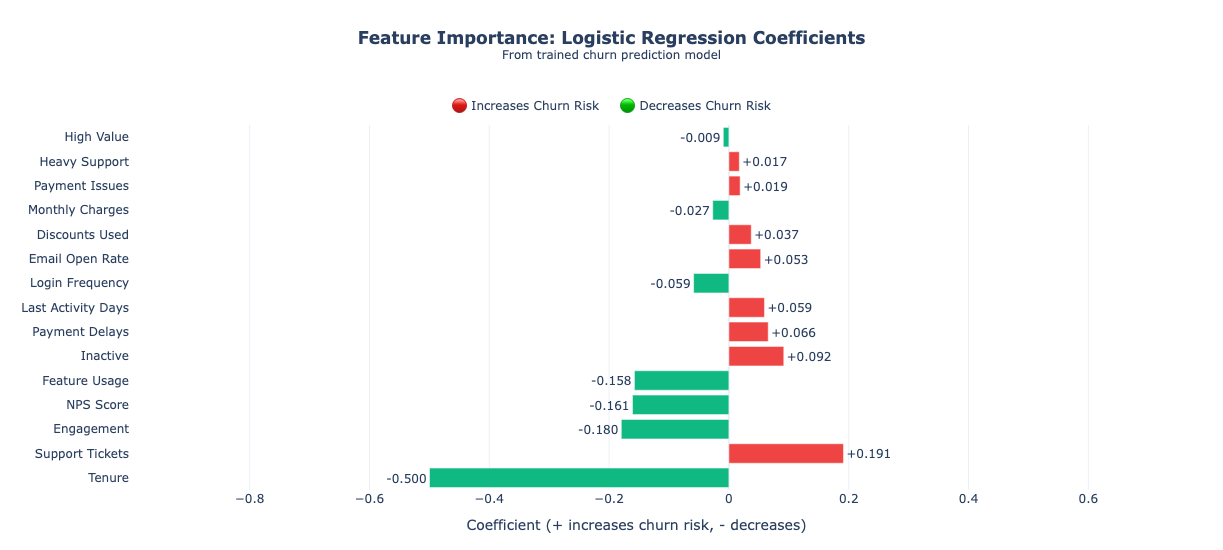

💾 Saved: ./viz/all_feature_importance.png

🎯 ACTIONABILITY ASSESSMENT

Actionability Scores (Business Impact Potential):
--------------------------------------------------

High Actionability:
   • has_payment_issues
   • engagement_score
   • feature_usage_pct
   • email_open_rate
   • login_frequency_monthly

Medium Actionability:
   • support_tickets_90d
   • last_activity_days
   • is_inactive
   • discount_count
   • payment_delays_12m

Low Actionability:
   • nps_score
   • tenure_months
   • monthly_charges
   • is_high_value
   • is_heavy_support_user

⚖️ COMBINED SCORING: Importance × Actionability

Feature                      |Coef|     Action   Combined  
------------------------------------------------------------
engagement_score             0.1796     High     0.5388    
tenure_months                0.4997     Low      0.4997    
feature_usage_pct            0.1577     High     0.4730    
support_tickets_90d          0.1913     Medium   0.3826    
is_inactive            

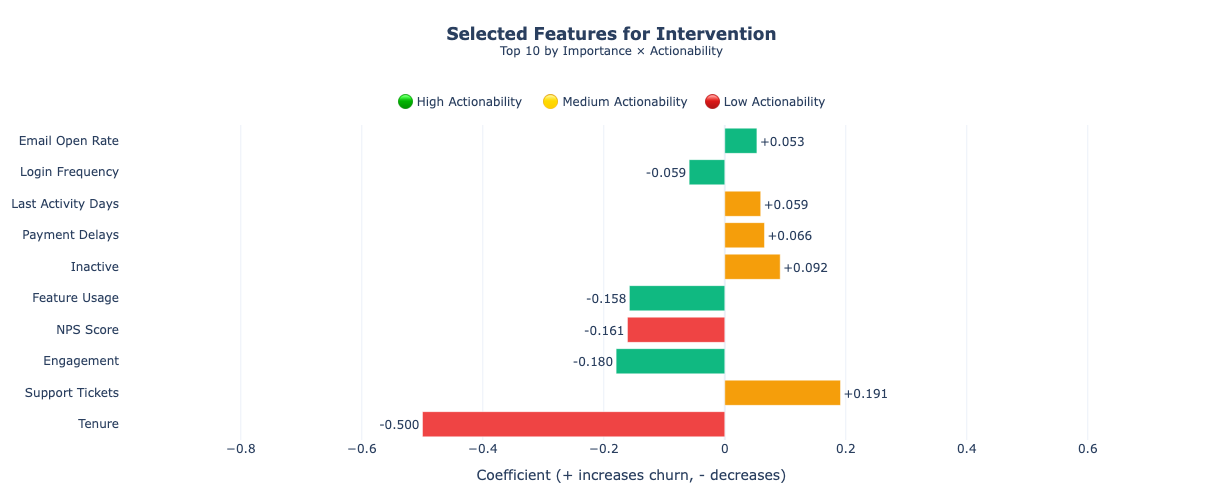

💾 Saved: ./viz/feature_weights.png

✅ FEATURE SELECTION COMPLETE
   10 features selected for Predictive Agent
   Model coefficients from: CHURN_MODEL (trained Logistic Regression)


In [22]:
# ============================================================
# FEATURE IMPORTANCE & SELECTION
# ============================================================
# Uses the TRAINED churn model coefficients to determine feature importance
# Combines ML importance with business actionability for final selection
# ============================================================

import plotly.graph_objects as go
import os

print("=" * 60)
print("📊 FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# ============================================================
# STEP 1: Extract Feature Importance from TRAINED Model
# ============================================================
# Using the model trained in Cell 7 (CHURN_MODEL)

if 'CHURN_MODEL' not in globals():
    raise NameError("❌ CHURN_MODEL not found. Please run Cell 7 (Model Training) first.")

print(f"\n✅ Using trained model: {type(CHURN_MODEL).__name__}")
print(f"   Features: {len(CHURN_FEATURES_LIST)}")

# Extract standardized coefficients (from model trained on scaled features)
coefficients = dict(zip(CHURN_FEATURES_LIST, CHURN_MODEL.coef_[0]))

# Sort by absolute value (importance)
coefficients_sorted = dict(sorted(coefficients.items(), 
                                  key=lambda x: abs(x[1]), reverse=True))

print(f"\n📊 Feature Coefficients (from trained Logistic Regression):")
print("-" * 60)
print(f"{'Feature':<30} {'Coefficient':<12} {'Direction':<15}")
print("-" * 60)
for feat, coef in coefficients_sorted.items():
    direction = "↑ increases churn" if coef > 0 else "↓ decreases churn"
    print(f"{feat:<30} {coef:>+10.4f}   {direction}")

# ============================================================
# STEP 2: Visualize ALL Feature Importances
# ============================================================
print(f"\n" + "=" * 60)
print("📊 VISUALIZING FEATURE IMPORTANCES")
print("=" * 60)

# Create viz directory
VIZ_DIR = "./viz"
os.makedirs(VIZ_DIR, exist_ok=True)

# Display names for visualization
ALL_FEATURE_DISPLAY_NAMES = {
    'tenure_months': 'Tenure', 'monthly_charges': 'Monthly Charges',
    'login_frequency_monthly': 'Login Frequency', 'feature_usage_pct': 'Feature Usage',
    'support_tickets_90d': 'Support Tickets', 'payment_delays_12m': 'Payment Delays',
    'discount_count': 'Discounts Used', 'nps_score': 'NPS Score',
    'email_open_rate': 'Email Open Rate', 'last_activity_days': 'Last Activity Days',
    'engagement_score': 'Engagement', 'is_high_value': 'High Value',
    'has_payment_issues': 'Payment Issues', 'is_heavy_support_user': 'Heavy Support',
    'is_inactive': 'Inactive'
}

features_display = [ALL_FEATURE_DISPLAY_NAMES.get(f, f) for f in coefficients_sorted.keys()]
coef_values = list(coefficients_sorted.values())
colors_all = ['#EF4444' if c > 0 else '#10B981' for c in coef_values]

fig_all = go.Figure(go.Bar(
    x=coef_values, y=features_display, orientation='h',
    marker_color=colors_all, 
    text=[f'{c:+.3f}' for c in coef_values],
    textposition='outside'
))

fig_all.update_layout(
    title={
        'text': '<b>Feature Importance: Logistic Regression Coefficients</b><br><sup>From trained churn prediction model</sup><br><br><span style="font-size:12px">🔴 Increases Churn Risk     🟢 Decreases Churn Risk</span>',
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.92,
        'yanchor': 'top'
    },
    xaxis_title='Coefficient (+ increases churn risk, - decreases)',
    template='plotly_white', 
    height=550,
    width=850,
    margin=dict(l=130, r=80, t=125, b=60),  # Increased TOP margin for legend in title
    xaxis=dict(range=[min(coef_values) - 0.5, max(coef_values) + 0.5])
)

fig_all.show()

# Save PNG
try:
    fig_all.write_image(f"{VIZ_DIR}/all_feature_importance.png", width=850, height=550, scale=2)
    print(f"💾 Saved: {VIZ_DIR}/all_feature_importance.png")
except Exception as e:
    print(f"⚠️ Could not save PNG: {e}")

# ============================================================
# STEP 3: Define Business Actionability
# ============================================================
print(f"\n" + "=" * 60)
print("🎯 ACTIONABILITY ASSESSMENT")
print("=" * 60)

# Actionability scores based on business ability to influence
FEATURE_ACTIONABILITY = {
    # High (3) - Direct, immediate action possible
    'has_payment_issues': 3,        # Send payment reminder
    'engagement_score': 3,          # Re-engagement campaign
    'feature_usage_pct': 3,         # Training/onboarding
    'email_open_rate': 3,           # Improve email content
    'login_frequency_monthly': 3,   # Feature announcements
    
    # Medium (2) - Partial influence
    'support_tickets_90d': 2,       # Improve support quality
    'last_activity_days': 2,        # Nudge emails
    'is_inactive': 2,               # Re-activation campaign
    'discount_count': 2,            # Strategic discounts
    'payment_delays_12m': 2,        # Payment plans
    
    # Low (1) - Cannot directly change
    'nps_score': 1,                 # Lagging indicator
    'tenure_months': 1,             # Historical
    'monthly_charges': 1,           # Pricing constraints
    'is_high_value': 1,             # Derived metric
    'is_heavy_support_user': 1      # Symptom, not cause
}

ACTIONABILITY_LABELS = {3: 'High', 2: 'Medium', 1: 'Low'}
ACTIONABILITY_COLORS = {3: '#10B981', 2: '#F59E0B', 1: '#EF4444'}

print(f"\nActionability Scores (Business Impact Potential):")
print("-" * 50)
for level in [3, 2, 1]:
    print(f"\n{ACTIONABILITY_LABELS[level]} Actionability:")
    for feat, score in FEATURE_ACTIONABILITY.items():
        if score == level and feat in CHURN_FEATURES_LIST:
            print(f"   • {feat}")

# ============================================================
# STEP 4: Combine Importance × Actionability
# ============================================================
print(f"\n" + "=" * 60)
print("⚖️ COMBINED SCORING: Importance × Actionability")
print("=" * 60)

feature_scores = {}
for feat in CHURN_FEATURES_LIST:
    coef = coefficients[feat]
    importance = abs(coef)
    actionability = FEATURE_ACTIONABILITY.get(feat, 1)
    combined_score = importance * actionability
    feature_scores[feat] = {
        'coefficient': coef,
        'importance': importance,
        'actionability': actionability,
        'actionability_label': ACTIONABILITY_LABELS[actionability],
        'combined_score': combined_score
    }

# Sort by combined score
feature_scores_sorted = dict(sorted(
    feature_scores.items(),
    key=lambda x: x[1]['combined_score'],
    reverse=True
))

print(f"\n{'Feature':<28} {'|Coef|':<10} {'Action':<8} {'Combined':<10}")
print("-" * 60)
for feat, scores in feature_scores_sorted.items():
    print(f"{feat:<28} {scores['importance']:<10.4f} {scores['actionability_label']:<8} {scores['combined_score']:<10.4f}")

# ============================================================
# STEP 5: Select Top Features for Intervention Agent
# ============================================================
print(f"\n" + "=" * 60)
print("✅ FINAL FEATURE SELECTION")
print("=" * 60)

TOP_N_FEATURES = 10
SELECTED_FEATURES = list(feature_scores_sorted.keys())[:TOP_N_FEATURES]
FEATURE_WEIGHTS = {feat: round(coefficients[feat], 4) for feat in SELECTED_FEATURES}

print(f"\n📊 Top {TOP_N_FEATURES} Features (for Predictive Agent):")
print("-" * 50)
for i, (feat, weight) in enumerate(FEATURE_WEIGHTS.items(), 1):
    direction = "↑ churn" if weight > 0 else "↓ churn"
    action = feature_scores[feat]['actionability_label']
    print(f"   {i:2}. {feat:<28} {weight:>+.4f}  [{action}]")

# ============================================================
# STEP 6: Visualize Selected Features (LEGEND AT TOP)
# ============================================================
features_final = [ALL_FEATURE_DISPLAY_NAMES.get(f, f) for f in SELECTED_FEATURES]
weights_final = [FEATURE_WEIGHTS[f] for f in SELECTED_FEATURES]
action_final = [feature_scores[f]['actionability_label'] for f in SELECTED_FEATURES]

# Sort by absolute weight for display
sorted_data = sorted(zip(features_final, weights_final, action_final), 
                     key=lambda x: abs(x[1]), reverse=True)
features_sorted = [d[0] for d in sorted_data]
weights_sorted = [d[1] for d in sorted_data]
action_sorted = [d[2] for d in sorted_data]

colors_final = []
for a in action_sorted:
    if a == 'High': colors_final.append('#10B981')
    elif a == 'Medium': colors_final.append('#F59E0B')
    else: colors_final.append('#EF4444')

fig_selected = go.Figure(go.Bar(
    x=weights_sorted, y=features_sorted, orientation='h',
    marker_color=colors_final, 
    text=[f'{w:+.3f}' for w in weights_sorted],
    textposition='outside'
))

fig_selected.update_layout(
    title={
        'text': f'<b>Selected Features for Intervention</b><br><sup>Top {TOP_N_FEATURES} by Importance × Actionability</sup><br><br><span style="font-size:12px">🟢 High Actionability     🟡 Medium Actionability    🔴 Low Actionability</span>',
        'x': 0.5,
        'xanchor': 'center',
        'y': 0.92,
        'yanchor': 'top'
    },
    xaxis_title='Coefficient (+ increases churn, - decreases)',
    template='plotly_white', 
    height=500,
    width=800,
    margin=dict(l=120, r=80, t=125, b=60),  # Increased TOP margin for legend in title
    xaxis=dict(range=[min(weights_sorted) - 0.5, max(weights_sorted) + 0.5])
)

fig_selected.show()

# Save PNG
try:
    fig_selected.write_image(f"{VIZ_DIR}/feature_weights.png", width=800, height=500, scale=2)
    print(f"💾 Saved: {VIZ_DIR}/feature_weights.png")
except Exception as e:
    print(f"⚠️ Could not save PNG: {e}")

print(f"\n✅ FEATURE SELECTION COMPLETE")
print(f"   {len(FEATURE_WEIGHTS)} features selected for Predictive Agent")
print(f"   Model coefficients from: CHURN_MODEL (trained Logistic Regression)")

In [23]:
if not globals().get("ADK_AVAILABLE", False):
    print("⚠️ Skipping Agent Definitions (Orchestrator): ADK/GenAI dependencies not installed.")
else:
    # ============================================================
    # MAIN ORCHESTRATOR AGENT
    # This is the primary agent with all tools
    # ============================================================

    # Initialize code executor
    code_executor = BuiltInCodeExecutor()

    # Create sub-agents for the orchestrator
    behavioral_agent = Agent(
        name="BehavioralMonitoringAgent",
        model=LLM_MODEL,
        description="Real-time customer behavior analysis agent",
        instruction="""You are a Behavioral Monitoring Agent. Analyze customer behavior patterns.
        Use get_customer_behavior to fetch data and identify early warning signals.""",
        tools=[get_customer_behavior],
        code_executor=code_executor
    )

    predictive_agent = Agent(
        name="PredictiveAnalyticsAgent",
        model=LLM_MODEL,
        description="Churn probability forecasting agent",
        instruction="""You are a Predictive Analytics Agent. Calculate churn risk scores.
        Use calculate_churn_score for predictions and list_at_risk_customers for prioritization.""",
        tools=[calculate_churn_score, run_survival_analysis, list_at_risk_customers],
        code_executor=code_executor
    )

    intervention_agent = Agent(
        name="InterventionStrategyAgent",
        model=LLM_MODEL,
        description="Retention intervention recommendation agent",
        instruction="""You are an Intervention Strategy Agent. Recommend personalized interventions.
        Use recommend_intervention with churn data to generate retention strategies.""",
        tools=[recommend_intervention, get_customer_behavior],
        code_executor=code_executor
    )

    evaluation_agent = Agent(
        name="EvaluationAgent",
        model=LLM_MODEL,
        description="Performance evaluation agent",
        instruction="""You are an Evaluation Agent. Assess system effectiveness and track metrics.
        Use survival analysis and at-risk lists to measure performance.""",
        tools=[run_survival_analysis, list_at_risk_customers],
        code_executor=code_executor
    )

    # Main Orchestrator with sub-agents
    orchestrator_agent = Agent(
        name="ChurnPreventionOrchestrator",
        model=LLM_MODEL,
        description="Main orchestrator for the Proactive Churn Prevention System",
        instruction="""You are the Orchestrator for the Proactive Churn Prevention Multi-Agent System.
    
    Coordinate the workflow:
    1. Gather behavioral data with get_customer_behavior
    2. Calculate churn probability with calculate_churn_score
    3. Recommend interventions with recommend_intervention

    For batch requests:
    1. Use list_at_risk_customers to find priority targets
    2. Analyze top customers individually
    3. Generate intervention recommendations

    Always provide actionable insights with specific metrics.""",
        tools=[
            get_customer_behavior,
            calculate_churn_score,
            recommend_intervention,
            run_survival_analysis,
            list_at_risk_customers
        ],
        code_executor=code_executor,
        sub_agents=[behavioral_agent, predictive_agent, intervention_agent, evaluation_agent]
    )

    print("✅ Orchestrator Agent defined with 4 sub-agents")

✅ Orchestrator Agent defined with 4 sub-agents


In [24]:
if not globals().get("ADK_AVAILABLE", False):
    print("⚠️ Skipping Agent Definitions (Sequential Workflow): ADK/GenAI dependencies not installed.")
else:
    # ============================================================
    # SEQUENTIAL WORKFLOW AGENT
    # IMPORTANT: Create NEW agent instances (agents can only have one parent)
    # ============================================================

    # Create separate instances for sequential workflow
    behavioral_agent_seq = Agent(
        name="BehavioralAgent_Sequential",
        model=LLM_MODEL,
        description="Behavioral analysis for sequential workflow",
        instruction="""Analyze customer behavior and pass insights to the next agent.
        Use get_customer_behavior to fetch data.""",
        tools=[get_customer_behavior]
    )

    predictive_agent_seq = Agent(
        name="PredictiveAgent_Sequential",
        model=LLM_MODEL,
        description="Prediction for sequential workflow",
        instruction="""Calculate churn probability based on behavioral data.
        Use calculate_churn_score and pass results to intervention agent.""",
        tools=[calculate_churn_score, list_at_risk_customers]
    )

    intervention_agent_seq = Agent(
        name="InterventionAgent_Sequential",
        model=LLM_MODEL,
        description="Intervention for sequential workflow",
        instruction="""Generate retention recommendations based on predictions.
        Use recommend_intervention with the churn data.""",
        tools=[recommend_intervention]
    )

    sequential_workflow = SequentialAgent(
        name="ChurnAnalysisWorkflow",
        description="Sequential workflow: Behavior → Prediction → Intervention",
        sub_agents=[behavioral_agent_seq, predictive_agent_seq, intervention_agent_seq]
    )

    print("✅ Sequential Workflow Agent defined")

✅ Sequential Workflow Agent defined


In [25]:
if not globals().get("ADK_AVAILABLE", False):
    print("⚠️ Skipping Agent Definitions (Parallel Workflow): ADK/GenAI dependencies not installed.")
else:
    # ============================================================
    # PARALLEL MONITORING AGENT
    # Create NEW agent instances for parallel execution
    # ============================================================

    engagement_monitor = Agent(
        name="EngagementMonitor",
        model=LLM_MODEL,
        description="Monitors engagement metrics",
        instruction="""Monitor customer engagement: login frequency, feature adoption, email engagement.
        Report concerning drops in engagement.""",
        tools=[get_customer_behavior]
    )

    payment_monitor = Agent(
        name="PaymentMonitor",
        model=LLM_MODEL,
        description="Monitors payment health",
        instruction="""Monitor payment health: delays, failures, subscription changes.
        Flag payment-related risk signals.""",
        tools=[get_customer_behavior]
    )

    support_monitor = Agent(
        name="SupportMonitor",
        model=LLM_MODEL,
        description="Monitors support interactions",
        instruction="""Monitor support interactions: ticket volume, sentiment, resolution rates.
        Identify customers with escalating support needs.""",
        tools=[get_customer_behavior]
    )

    parallel_monitoring = ParallelAgent(
        name="ParallelMonitoringSystem",
        description="Parallel monitoring: Engagement + Payment + Support",
        sub_agents=[engagement_monitor, payment_monitor, support_monitor]
    )

    print("✅ Parallel Monitoring Agent defined")

✅ Parallel Monitoring Agent defined


In [26]:
# ============================================================
# LOOP AGENT FOR CONTINUOUS EVALUATION
# Create NEW agent instances for loop execution
# ============================================================

if not globals().get("ADK_AVAILABLE", False):
    print("⚠️ Skipping Loop Agent: ADK/GenAI dependencies not installed.")
else:
    batch_evaluator = Agent(
        name="BatchEvaluator_Loop",
        model=LLM_MODEL,
        description="Evaluates batches of customers",
        instruction="""Process customer batches:
        1. Get at-risk customers
        2. Analyze top priority ones
        3. Generate recommendations
        Continue until all high-risk customers evaluated.""",
        tools=[list_at_risk_customers, calculate_churn_score, recommend_intervention]
    )

    metrics_tracker = Agent(
        name="MetricsTracker_Loop",
        model=LLM_MODEL,
        description="Tracks evaluation metrics",
        instruction="""Track and summarize metrics across batches.
        Use survival analysis for cohort insights.""",
        tools=[run_survival_analysis, list_at_risk_customers]
    )

    continuous_evaluation_loop = LoopAgent(
        name="ContinuousEvaluationLoop",
        description="Continuously evaluates customer churn patterns",
        sub_agents=[batch_evaluator, metrics_tracker],
        max_iterations=3  # Limit for demo
    )

    print("✅ Loop Agent for continuous evaluation defined")


✅ Loop Agent for continuous evaluation defined


## Section 5: Sessions & Memory

In [28]:
if not globals().get("ADK_AVAILABLE", False):
    print("⚠️ Skipping Session Service: ADK/GenAI dependencies not installed.")
else:
    from datetime import datetime

    # ============================================================
    # SESSION SERVICE
    # ============================================================

    session_service = InMemorySessionService()

    async def create_session(user_id: str):
        """Create a session for a user."""
        session_id = f"session_{user_id}_{datetime.now().strftime('%Y%m%d%H%M%S')}"
        session = await session_service.create_session(
            app_name=APP_NAME,
            user_id=user_id,
            session_id=session_id
        )
        return session

    print("✅ Session Service initialized")


✅ Session Service initialized


In [29]:
# ============================================================
# MEMORY STORE
# ============================================================

class CustomerMemoryStore:
    """Long-term memory for customer interactions."""
    
    def __init__(self):
        self.interactions = {}
        self.interventions = {}
        self.risk_history = {}
        
    def add_interaction(self, customer_id: str, interaction: Dict[str, Any]):
        if customer_id not in self.interactions:
            self.interactions[customer_id] = []
        interaction['timestamp'] = datetime.now().isoformat()
        self.interactions[customer_id].append(interaction)
        
    def add_intervention(self, customer_id: str, intervention: Dict[str, Any]):
        if customer_id not in self.interventions:
            self.interventions[customer_id] = []
        intervention['timestamp'] = datetime.now().isoformat()
        self.interventions[customer_id].append(intervention)
        
    def add_risk_score(self, customer_id: str, score: float, tier: str):
        if customer_id not in self.risk_history:
            self.risk_history[customer_id] = []
        self.risk_history[customer_id].append({
            'score': score,
            'tier': tier,
            'timestamp': datetime.now().isoformat()
        })

    def clear(self):
        """Clear all stored memories."""
        self._memories.clear()
        
    def get_summary(self) -> Dict[str, Any]:
        return {
            'total_customers': len(set(list(self.interactions.keys()) + list(self.interventions.keys()))),
            'total_interactions': sum(len(v) for v in self.interactions.values()),
            'total_interventions': sum(len(v) for v in self.interventions.values()),
            'total_risk_assessments': sum(len(v) for v in self.risk_history.values())
        }

memory_store = CustomerMemoryStore()
print("✅ Memory Store initialized")

✅ Memory Store initialized


## Section 6: Observability

In [31]:
# ============================================================
# METRICS COLLECTOR
# ============================================================

import time
from functools import wraps

class MetricsCollector:
    def __init__(self):
        self.metrics = {
            'requests': [],
            'latencies': [],
            'errors': [],
            'tool_calls': []
        }
        
    def record_request(self, agent_name: str, success: bool, latency_ms: float):
        self.metrics['requests'].append({
            'timestamp': datetime.now().isoformat(),
            'agent': agent_name,
            'success': success,
            'latency_ms': latency_ms
        })
        self.metrics['latencies'].append(latency_ms)
        
    def record_error(self, agent_name: str, error_type: str, error_msg: str):
        self.metrics['errors'].append({
            'timestamp': datetime.now().isoformat(),
            'agent': agent_name,
            'error_type': error_type,
            'error_msg': error_msg
        })
        
    def get_summary(self) -> Dict[str, Any]:
        latencies = self.metrics['latencies']
        requests = self.metrics['requests']
        return {
            'total_requests': len(requests),
            'success_rate': sum(1 for r in requests if r['success']) / max(len(requests), 1),
            'avg_latency_ms': np.mean(latencies) if latencies else 0,
            'total_errors': len(self.metrics['errors'])
        }

metrics_collector = MetricsCollector()

def trace_execution(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        try:
            result = func(*args, **kwargs)
            latency = (time.time() - start) * 1000
            metrics_collector.record_request(func.__name__, True, latency)
            return result
        except Exception as e:
            latency = (time.time() - start) * 1000
            metrics_collector.record_error(func.__name__, type(e).__name__, str(e))
            metrics_collector.record_request(func.__name__, False, latency)
            raise
    return wrapper

print("✅ Observability components initialized")

✅ Observability components initialized


## Section 7: Local Testing

In [33]:
if not globals().get("ADK_AVAILABLE", False):
    print("⚠️ Skipping Agent Runner: ADK/GenAI dependencies not installed.")
else:
    # ============================================================
    # AGENT RUNNER
    # ============================================================
    APP_NAME = globals().get('APP_NAME', 'agents')
    runner = Runner(
        agent=orchestrator_agent,
        app_name=APP_NAME,
        session_service=session_service
    )

    print("✅ Agent Runner initialized")


✅ Agent Runner initialized


In [34]:
# Test tools directly
print("=" * 60)
print("TOOL TESTS")
print("=" * 60)

test_customer = "CUST_000001"

# Test 1: Behavior
print(f"\n1. Customer Behavior ({test_customer}):")
behavior = get_customer_behavior(test_customer)
print(f"   Engagement Score: {behavior['engagement']['engagement_score']}")
print(f"   Risk Flags: {behavior['risk_flags']}")

# Test 2: Churn Score
print(f"\n2. Churn Score:")
score = calculate_churn_score(test_customer)
print(f"   Probability: {score['churn_probability']:.2%}")
print(f"   Risk Tier: {score['risk_tier']}")
print(f"   Risk Factors: {score['key_risk_factors']}")

# Test 3: Intervention
print(f"\n3. Intervention Recommendation:")
intervention = recommend_intervention(
    test_customer, 
    score['churn_probability'], 
    score['key_risk_factors']
)
print(f"   Channel: {intervention['intervention_channel']}")
print(f"   Action: {intervention['intervention_action']}")
print(f"   Priority: {intervention['priority']}")
print(f"   Expected ROI: {intervention['roi_estimate']}x")

# Test 4: At-Risk List
print(f"\n4. At-Risk Customers (top 3):")
at_risk = list_at_risk_customers(min_probability=0.6, limit=3)
print(f"   Count: {at_risk['count']}")
print(f"   Total CLV at Risk: ${at_risk['total_clv_at_risk']:,.0f}")

# Test 5: Survival Analysis
print(f"\n5. Survival Analysis:")
survival = run_survival_analysis()
print(f"   Sample Size: {survival['sample_size']}")
print(f"   Event Rate: {survival['event_rate']:.1%}")

2025-12-17 11:57:21,688 | __main__ | INFO | Fetching behavior data for CUST_000001
2025-12-17 11:57:21,700 | __main__ | INFO | Retrieving churn prediction for CUST_000001
2025-12-17 11:57:21,706 | __main__ | INFO | Generating intervention for CUST_000001
2025-12-17 11:57:21,711 | __main__ | INFO | Listing at-risk customers (prob >= 0.6)
2025-12-17 11:57:21,716 | ChurnPreventionAgents | INFO | Running survival analysis for risk tier: all


TOOL TESTS

1. Customer Behavior (CUST_000001):
   Engagement Score: 41.08
   Risk Flags: {'is_high_value': True, 'has_payment_issues': True, 'is_heavy_support_user': True, 'is_inactive': False}

2. Churn Score:
   Probability: 49.28%
   Risk Tier: Medium
   Risk Factors: ['Payment issues detected', 'High support ticket volume']

3. Intervention Recommendation:
   Channel: Discount
   Action: Flexible payment plan offer
   Priority: 3
   Expected ROI: 24.5x

4. At-Risk Customers (top 3):
   Count: 3
   Total CLV at Risk: $361

5. Survival Analysis:
   Sample Size: 3000
   Event Rate: 19.5%


In [35]:
# Record in memory store
memory_store.add_interaction(test_customer, {"type": "analysis", "result": score})
memory_store.add_intervention(test_customer, intervention)
memory_store.add_risk_score(test_customer, score['churn_probability'], score['risk_tier'])

print("\nMemory Store Summary:")
print(json.dumps(memory_store.get_summary(), indent=2))


Memory Store Summary:
{
  "total_customers": 1,
  "total_interactions": 1,
  "total_interventions": 1,
  "total_risk_assessments": 1
}


In [36]:
if not globals().get("ADK_AVAILABLE", False):
    print("⚠️ Skipping Agent Query Test: ADK/GenAI dependencies not installed.")
else:
    # Test agent query (requires API key)
    print("\n" + "=" * 60)
    print("AGENT QUERY TEST")
    print("=" * 60)

    async def test_agent_query(query: str, user_id: str = "test_user"):
        """Test agent with a query."""
        try:
            session = await create_session(user_id)
        
            content = genai_types.Content(
                role="user",
                parts=[genai_types.Part(text=query)]
            )
        
            response_text = ""
            async for event in runner.run_async(
                user_id=user_id,
                session_id=session.id,
                new_message=content
            ):
                if event.is_final_response():
                    if event.content and event.content.parts:
                        response_text = event.content.parts[0].text
        
            return response_text
        except Exception as e:
            return f"Error: {e}"

    # Example queries (uncomment to test with API)
    test_queries = [
        "Analyze churn risk for customer CUST_000001 and recommend interventions",
        "List the top 5 customers at risk of churning",
        "What's the overall churn rate in our customer base?"
    ]

    print("\nExample queries (uncomment to run with API):")
    for i, q in enumerate(test_queries, 1):
        print(f"  {i}. {q}")

    async def main():
        print("\nExample queries:")
        for i, q in enumerate(test_queries, 1):
            print(f"  {i}. {q}")

        # The loop now runs inside a single async context
        for query in test_queries:
            print(f"\nQuery: {query}")
        
            # We await the function directly, rather than starting/stopping the loop
            result = await test_agent_query(query)
        
            print(f"Response: {result[:500]}...")

    # Run the main entry point once
    try:
        get_ipython  # type: ignore
        # Jupyter / IPython supports top-level await
        await main()
    except NameError:
        # Script fallback
        asyncio.run(main())



AGENT QUERY TEST

Example queries (uncomment to run with API):
  1. Analyze churn risk for customer CUST_000001 and recommend interventions
  2. List the top 5 customers at risk of churning
  3. What's the overall churn rate in our customer base?

Example queries:
  1. Analyze churn risk for customer CUST_000001 and recommend interventions
  2. List the top 5 customers at risk of churning
  3. What's the overall churn rate in our customer base?

Query: Analyze churn risk for customer CUST_000001 and recommend interventions
Response: Error: Missing key inputs argument! To use the Google AI API, provide (`api_key`) arguments. To use the Google Cloud API, provide (`vertexai`, `project` & `location`) arguments....

Query: List the top 5 customers at risk of churning
Response: Error: Session with id session_test_user_20251217115721 already exists....

Query: What's the overall churn rate in our customer base?
Response: Error: Session with id session_test_user_20251217115721 already exists.

## Section 8: Model Evaluation

In [38]:
# ============================================================
# MODEL EVALUATION
# ============================================================
# Evaluate the trained churn prediction model on the TEST set
# This measures how well the model generalizes to unseen data
# ============================================================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report
)
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("=" * 60)
print("📈 CHURN PREDICTION MODEL EVALUATION")
print("=" * 60)

# ============================================================
# VERIFY WE'RE USING MODEL PREDICTIONS
# ============================================================
if 'CHURN_MODEL' not in globals():
    print("⚠️ CHURN_MODEL not found. Using existing churn_probability column.")
else:
    print(f"✅ Using predictions from trained {type(CHURN_MODEL).__name__}")

# ============================================================
# GET TEST SET PREDICTIONS
# ============================================================
# test_indices was saved during model training (Cell 7)

if 'test_indices' not in globals():
    # Fallback: recreate test split
    from sklearn.model_selection import train_test_split
    _, test_indices = train_test_split(
        customer_df.index, test_size=0.2, 
        random_state=TRAINING_SEED, 
        stratify=customer_df['churned']
    )
    print("⚠️ Recreated test indices (should match original split)")

test_df = customer_df.loc[test_indices].copy()

print(f"\n📊 Test Set Overview:")
print(f"   Samples: {len(test_df)}")
print(f"   Actual churn rate: {test_df['churned'].mean():.1%}")

# Extract predictions and actuals
y_true = test_df['churned'].values
y_prob = test_df['churn_probability'].values  # MODEL PREDICTIONS

# ============================================================
# THRESHOLD ANALYSIS
# ============================================================
print(f"\n" + "=" * 60)
print("📊 THRESHOLD ANALYSIS")
print("=" * 60)

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

print(f"\n{'Threshold':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10}")
print("-" * 52)

best_f1 = 0
best_threshold = 0.5

for thresh in thresholds:
    y_pred = (y_prob >= thresh).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh
    
    print(f"{thresh:<12.1f} {acc:<10.3f} {prec:<10.3f} {rec:<10.3f} {f1:<10.3f}")

print(f"\n🎯 Best threshold by F1: {best_threshold} (F1={best_f1:.3f})")

# ============================================================
# FINAL EVALUATION (at best threshold)
# ============================================================
threshold = best_threshold
y_pred = (y_prob >= threshold).astype(int)

print(f"\n" + "=" * 60)
print(f"📊 FINAL MODEL PERFORMANCE (threshold={threshold})")
print("=" * 60)

auc = roc_auc_score(y_true, y_prob)

print(f"\n🎯 Key Metrics:")
print(f"   AUC-ROC:   {auc:.4f}")
print(f"   Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"   Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
print(f"   Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
print(f"   F1 Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f"\n📊 Confusion Matrix:")
print(f"              Predicted")
print(f"              Retained  Churned")
print(f"   Actual")
print(f"   Retained     {tn:5d}    {fp:5d}")
print(f"   Churned      {fn:5d}    {tp:5d}")

print(f"\n📊 Business Interpretation:")
print(f"   True Negatives (TN):  {tn} - Correctly identified retained customers")
print(f"   True Positives (TP):  {tp} - Correctly identified churners (can intervene!)")
print(f"   False Positives (FP): {fp} - Retained but flagged as risk (wasted effort)")
print(f"   False Negatives (FN): {fn} - Churned but missed (lost opportunity)")

# Calculate business impact
avg_clv = test_df['clv_estimate'].mean()
print(f"\n💰 Estimated Business Impact:")
print(f"   Average CLV: ${avg_clv:,.0f}")
print(f"   Correctly identified churners: {tp}")
print(f"   If 50% saved through intervention: {tp//2} customers")
print(f"   Estimated value saved: ${(tp//2) * avg_clv:,.0f}")

print(f"\n✅ Model evaluation complete!")


📈 CHURN PREDICTION MODEL EVALUATION
✅ Using predictions from trained LogisticRegression

📊 Test Set Overview:
   Samples: 600
   Actual churn rate: 19.5%

📊 THRESHOLD ANALYSIS

Threshold    Accuracy   Precision  Recall     F1        
----------------------------------------------------
0.3          0.337      0.222      0.957      0.360     
0.4          0.458      0.241      0.829      0.374     
0.5          0.608      0.270      0.590      0.370     
0.6          0.725      0.312      0.342      0.327     
0.7          0.790      0.385      0.128      0.192     

🎯 Best threshold by F1: 0.4 (F1=0.374)

📊 FINAL MODEL PERFORMANCE (threshold=0.4)

🎯 Key Metrics:
   AUC-ROC:   0.6576
   Accuracy:  0.4583
   Precision: 0.2413
   Recall:    0.8291
   F1 Score:  0.3738

📊 Confusion Matrix:
              Predicted
              Retained  Churned
   Actual
   Retained       178      305
   Churned         20       97

📊 Business Interpretation:
   True Negatives (TN):  178 - Correctly identi

In [39]:
# Business Impact
print("\n" + "=" * 60)
print("BUSINESS IMPACT")
print("=" * 60)

at_risk = test_df[test_df['churn_probability'] >= threshold]
total_clv_at_risk = at_risk['clv_estimate'].sum()
expected_lift = 0.30
avg_cost = 500

intervention_cost = len(at_risk) * avg_cost
expected_savings = total_clv_at_risk * expected_lift
roi = expected_savings / intervention_cost if intervention_cost > 0 else 0

print(f"\nAt-Risk Analysis:")
print(f"  Customers at risk: {len(at_risk)}")
print(f"  Total CLV at risk: ${total_clv_at_risk:,.0f}")

print(f"\nROI Projection:")
print(f"  Intervention cost: ${intervention_cost:,.0f}")
print(f"  Expected savings: ${expected_savings:,.0f}")
print(f"  Expected ROI: {roi:.1f}x")


BUSINESS IMPACT

At-Risk Analysis:
  Customers at risk: 402
  Total CLV at risk: $516,247

ROI Projection:
  Intervention cost: $201,000
  Expected savings: $154,874
  Expected ROI: 0.8x


In [40]:
# Success Criteria
print("\n" + "=" * 60)
print("SUCCESS CRITERIA")
print("=" * 60)

criteria = [
    ("Multi-Agent System", True, "Orchestrator + 4 sub-agents + Sequential/Parallel/Loop"),
    ("Custom Tools", True, "5 tools: churn_score, intervention, behavior, survival, at_risk"),
    ("Code Execution", True, "BuiltInCodeExecutor (ADK v1.0.0+ pattern)"),
    ("Sessions & Memory", True, "InMemorySessionService + CustomerMemoryStore"),
    ("Observability", True, "MetricsCollector + trace_execution"),
    ("ADK v1.0.0+ Compatible", True, "Agent class, separate agent instances per parent")
]

for name, passed, details in criteria:
    status = "✅" if passed else "❌"
    print(f"{status} {name}: {details}")


SUCCESS CRITERIA
✅ Multi-Agent System: Orchestrator + 4 sub-agents + Sequential/Parallel/Loop
✅ Custom Tools: 5 tools: churn_score, intervention, behavior, survival, at_risk
✅ Code Execution: BuiltInCodeExecutor (ADK v1.0.0+ pattern)
✅ Sessions & Memory: InMemorySessionService + CustomerMemoryStore
✅ Observability: MetricsCollector + trace_execution
✅ ADK v1.0.0+ Compatible: Agent class, separate agent instances per parent


## Section 9: A/B Testing Framework

In [42]:
# ============================================================
# A/B TESTING FRAMEWORK 
# ============================================================

import numpy as np
import pandas as pd
from scipy import stats
from typing import Dict, List, Tuple, Optional
from datetime import datetime
import random

print("=" * 60)
print("📊 A/B TESTING FRAMEWORK")
print("=" * 60)


# ============================================================
# SAMPLE SIZE CALCULATOR
# ============================================================

def calculate_sample_size(
    baseline_rate: float,
    minimum_detectable_effect: float,  # ABSOLUTE effect
    significance_level: float = 0.05,
    power: float = 0.80
    ) -> int:
    """
    Calculate required sample size per group using power analysis.
    
    Args:
        baseline_rate: Current churn rate (e.g., 0.15 for 15%)
        minimum_detectable_effect: ABSOLUTE reduction to detect (e.g., 0.05 for 5%)
        significance_level: Alpha (default 0.05)
        power: Statistical power (default 0.80)
        
    Returns:
        Required sample size per group
    """
    treatment_rate = baseline_rate - minimum_detectable_effect
    
    # Pooled proportion
    p_pooled = (baseline_rate + treatment_rate) / 2
    
    # Z-scores
    z_alpha = stats.norm.ppf(1 - significance_level / 2)
    z_beta = stats.norm.ppf(power)
    
    # Sample size formula for proportions
    numerator = (z_alpha * np.sqrt(2 * p_pooled * (1 - p_pooled)) + 
                 z_beta * np.sqrt(baseline_rate * (1 - baseline_rate) + 
                                   treatment_rate * (1 - treatment_rate))) ** 2
    denominator = (baseline_rate - treatment_rate) ** 2
    
    n = int(np.ceil(numerator / denominator))
    
    return n

📊 A/B TESTING FRAMEWORK


In [43]:
# ============================================================
# A/B TEST MANAGER 
# ============================================================

class ABTestManager:
    """
    A/B Test Manager with proper statistical simulation.
    
    VARIANT NAMES: ['Control', 'Email', 'Discount', 'Call', 'Combined']
    """
    
    def __init__(self):
        self.experiments = {}
        self.assignments = {}
        self.results = {}
        
    def create_experiment(
        self,
        name: str,
        intervention_type: str,
        control_rate: float,
        treatment_rate: float,
        sample_size_per_group: int,
        variants: List[str] = None
    ) -> str:
        """Create a new A/B test experiment."""
        if variants is None:
            variants = ['Control', 'Treatment']
            
        experiment_id = f"exp_{name}_{datetime.now().strftime('%Y%m%d%H%M%S')}"
        
        if treatment_rate >= control_rate:
            raise ValueError('treatment_rate must be lower than control_rate for churn reduction experiments.')
        effect_size = control_rate - treatment_rate
        if effect_size <= 0:
            raise ValueError('Effect size is zero; choose different control_rate and treatment_rate.')
        required_n = calculate_sample_size(control_rate, effect_size)
        is_powered = sample_size_per_group >= required_n
        
        self.experiments[experiment_id] = {
            "id": experiment_id,
            "name": name,
            "intervention_type": intervention_type,
            "variants": variants,
            "control_rate": control_rate,
            "treatment_rate": treatment_rate,
            "sample_size": sample_size_per_group,
            "required_sample_size": required_n,
            "adequately_powered": is_powered,
            "config": {
                "significance_level": 0.05,
                "minimum_detectable_effect": effect_size
            },
            "status": "active",
            "created_at": datetime.now().isoformat(),
            "participants": {v: [] for v in variants},
            "outcomes": {v: {"churned": 0, "retained": 0} for v in variants}
        }
        
        print(f"✅ Created experiment: {experiment_id}")
        print(f"   Intervention: {intervention_type}")
        print(f"   Control rate: {control_rate:.1%} | Treatment rate: {treatment_rate:.1%}")
        print(f"   Effect size: {effect_size:.1%} absolute ({effect_size/control_rate*100:.1f}% relative)")
        print(f"   Sample size: {sample_size_per_group} per group")
        print(f"   Required for 80% power: {required_n}")
        print(f"   Adequately powered: {'YES ✅' if is_powered else 'NO ⚠️'}")
        
        return experiment_id
    
    def run_experiment(self, experiment_id: str, seed: int = None) -> None:
        """Run the experiment simulation using GROUP-LEVEL rates."""
        seed = SEED if seed is None else int(seed)
        np.random.seed(seed)
        
        if experiment_id not in self.experiments:
            raise ValueError(f"Experiment {experiment_id} not found")
            
        exp = self.experiments[experiment_id]
        n = exp["sample_size"]
        
        # Simulate using GROUP-LEVEL binomial distribution
        control_churned = np.random.binomial(n, exp["control_rate"])
        treatment_churned = np.random.binomial(n, exp["treatment_rate"])
        
        # Store in outcomes - using 'Control' and 'Treatment'
        exp["outcomes"]["Control"] = {
            "churned": control_churned,
            "retained": n - control_churned
        }
        exp["outcomes"]["Treatment"] = {
            "churned": treatment_churned,
            "retained": n - treatment_churned
        }
        
        # Create participant IDs
        for i in range(n):
            exp["participants"]["Control"].append(f"ctrl_{i}")
            exp["participants"]["Treatment"].append(f"treat_{i}")
        
        print(f"\n📊 Experiment {exp['name']} completed:")
        print(f"   Control: {control_churned}/{n} churned ({control_churned/n:.1%})")
        print(f"   Treatment: {treatment_churned}/{n} churned ({treatment_churned/n:.1%})")
    
    def analyze_results(self, experiment_id: str) -> Dict:
        """Perform statistical analysis. Output format matches Executive Dashboard."""
        if experiment_id not in self.experiments:
            raise ValueError(f"Experiment {experiment_id} not found")
            
        exp = self.experiments[experiment_id]
        outcomes = exp["outcomes"]
        
        # Get Control and Treatment outcomes
        control = outcomes.get("Control", {"churned": 0, "retained": 0})
        treatment = outcomes.get("Treatment", {"churned": 0, "retained": 0})
        
        control_total = control["churned"] + control["retained"]
        treatment_total = treatment["churned"] + treatment["retained"]
        
        if control_total == 0 or treatment_total == 0:
            return {"status": "insufficient_data"}
        
        control_churn_rate = control["churned"] / control_total
        treatment_churn_rate = treatment["churned"] / treatment_total
        
        if control_churn_rate > 0:
            relative_lift = (control_churn_rate - treatment_churn_rate) / control_churn_rate
        else:
            relative_lift = 0
        absolute_lift = control_churn_rate - treatment_churn_rate
        
        # Chi-square test
        contingency_table = [
            [control["churned"], control["retained"]],
            [treatment["churned"], treatment["retained"]]
        ]
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
        
        # Validate chi-square assumptions (expected frequencies >= 5)
        min_expected = expected.min()
        if min_expected < 5:
            print(f"⚠️ Warning: Min expected frequency ({min_expected:.1f}) < 5. "
                  "Chi-square test may be unreliable for small samples.")
        
        # Confidence interval
        se = np.sqrt(
            (control_churn_rate * (1 - control_churn_rate) / control_total) +
            (treatment_churn_rate * (1 - treatment_churn_rate) / treatment_total)
        )
        z_score = stats.norm.ppf(0.975)
        ci_lower = absolute_lift - z_score * se
        ci_upper = absolute_lift + z_score * se
        
        significance_level = exp["config"]["significance_level"]
        is_significant = p_value < significance_level
        
        # Build results in DASHBOARD-COMPATIBLE FORMAT
        results = {
            "experiment_id": experiment_id,
            "experiment_name": exp["name"],
            "status": "complete",
            "sample_sizes": {
                "control": control_total,
                "treatment": treatment_total,
                "total": control_total + treatment_total
            },
            "churn_rates": {
                "control": round(control_churn_rate, 4),
                "treatment": round(treatment_churn_rate, 4)
            },
            "lift": {
                "absolute": round(absolute_lift, 4),
                "relative": round(relative_lift, 4),
                "relative_pct": f"{relative_lift * 100:.1f}%"
            },
            "statistical_tests": {
                "chi_square": round(chi2, 4),
                "p_value": round(p_value, 6),
                "degrees_of_freedom": dof
            },
            "confidence_interval_95": {
                "lower": round(ci_lower, 4),
                "upper": round(ci_upper, 4)
            },
            "conclusion": {
                "is_significant": is_significant,
                "significance_level": significance_level,
                "recommendation": self._get_recommendation(is_significant, relative_lift, p_value)
            }
        }
        
        self.results[experiment_id] = results
        return results
    
    def _get_recommendation(self, is_significant: bool, relative_lift: float, p_value: float) -> str:
        """Generate recommendation based on results."""
        if not is_significant:
            if p_value < 0.10:
                return "Results trending positive but not yet significant. Consider extending the experiment."
            else:
                return "No significant difference detected. Consider testing alternative interventions."
        
        if relative_lift > 0.30:
            return "🎉 Strong positive impact! Recommend rolling out to all customers immediately."
        elif relative_lift > 0.15:
            return "✅ Significant positive impact. Recommend gradual rollout with continued monitoring."
        elif relative_lift > 0:
            return "📈 Modest positive impact. Consider cost-benefit analysis before full rollout."
        else:
            return "⚠️ Treatment shows higher churn. Stop experiment and investigate."
    
    def get_experiment_status(self, experiment_id: str) -> Dict:
        """Get current status of an experiment."""
        if experiment_id not in self.experiments:
            raise ValueError(f"Experiment {experiment_id} not found")
            
        exp = self.experiments[experiment_id]
        outcomes = exp["outcomes"]
        
        return {
            "experiment_id": experiment_id,
            "name": exp["name"],
            "status": exp["status"],
            "adequately_powered": exp["adequately_powered"],
            "variants": {
                variant: {
                    "participants": len(exp["participants"][variant]),
                    "outcomes": outcomes[variant]
                }
                for variant in exp["variants"]
            }
        }


In [44]:
# ============================================================
# INITIALIZE AND RUN A/B TEST
# ============================================================

# Initialize the A/B Test Manager
ab_manager = ABTestManager()
print("✅ ABTestManager initialized")

✅ ABTestManager initialized


In [45]:
# ============================================================
# SAMPLE SIZE CALCULATION
# ============================================================

print("\n" + "=" * 60)
print("📏 SAMPLE SIZE CALCULATION")
print("=" * 60)

baseline_churn_rate = 0.18  # 18% baseline
target_effect = 0.05        # 5% ABSOLUTE reduction (18% -> 13%)

required_sample = calculate_sample_size(
    baseline_rate=baseline_churn_rate,
    minimum_detectable_effect=target_effect,
    significance_level=0.05,
    power=0.80
)

print(f"\nBaseline churn rate: {baseline_churn_rate:.1%}")
print(f"Target treatment rate: {baseline_churn_rate - target_effect:.1%}")
print(f"Minimum detectable effect: {target_effect:.1%} absolute")
print(f"Significance level (α): 0.05")
print(f"Statistical power (1-β): 0.80")
print(f"\n📊 Required sample size per group: {required_sample}")
print(f"📊 Total sample size needed: {required_sample * 2}")


📏 SAMPLE SIZE CALCULATION

Baseline churn rate: 18.0%
Target treatment rate: 13.0%
Minimum detectable effect: 5.0% absolute
Significance level (α): 0.05
Statistical power (1-β): 0.80

📊 Required sample size per group: 822
📊 Total sample size needed: 1644


In [46]:
# ============================================================
# RUN MAIN A/B EXPERIMENT (Binary: Control vs Treatment)
# ============================================================

SEED = globals().get("SEED", 11)
ALPHA = globals().get("ALPHA", 0.05)

print("\n" + "=" * 60)
print("🧪 RUNNING BINARY A/B TEST (Control vs Treatment)")
print("=" * 60)

experiment_id = ab_manager.create_experiment(
    name="re_engagement_campaign",
    intervention_type="Re-engagement Campaign with Training",
    control_rate=0.18,      # baseline churn rate
    treatment_rate=0.10,    # treatment churn rate
    sample_size_per_group=1000,
    variants=["Control", "Treatment"]
)

ab_manager.run_experiment(experiment_id, seed=SEED)
results = ab_manager.analyze_results(experiment_id)

print("\n" + "=" * 60)
print("📈 A/B TEST RESULTS")
print("=" * 60)

print(f"\n{'='*50}")
print(f"EXPERIMENT: {results['experiment_name']}")
print(f"{'='*50}")

print("\n📊 Sample Sizes:")
print(f"   Control: {results['sample_sizes']['control']} customers")
print(f"   Treatment: {results['sample_sizes']['treatment']} customers")

print("\n📉 Churn Rates:")
print(f"   Control: {results['churn_rates']['control']:.1%}")
print(f"   Treatment: {results['churn_rates']['treatment']:.1%}")

print("\n📈 Lift:")
print(f"   Absolute: {results['lift']['absolute']:.2%} reduction in churn")
print(f"   Relative: {results['lift']['relative_pct']} improvement")

print("\n🔬 Statistical Significance:")
print(f"   Chi-square: {results['statistical_tests']['chi_square']:.4f}")
print(f"   P-value: {results['statistical_tests']['p_value']:.6f}")
print(f"   Significant at α={ALPHA:.2f}: {'✅ YES' if results['conclusion']['is_significant'] else '❌ NO'}")

print("\n📏 95% Confidence Interval:")
print(f"   [{results['confidence_interval_95']['lower']:.2%}, {results['confidence_interval_95']['upper']:.2%}]")

print("\n💡 Recommendation:")
print(f"   {results['conclusion']['recommendation']}")

# ============================================================
# MULTI-VARIANT TEST: ['Control', 'Email', 'Discount', 'Call', 'Combined']
# 2,000 participants total (400 per variant)
# ============================================================

from scipy import stats
import numpy as np

print("\n" + "=" * 60)
print("🔬 MULTI-VARIANT TEST")
print("   Variants: ['Control', 'Email', 'Discount', 'Call', 'Combined']")
print("   Participants: 2,000 total (400 per variant)")
print("=" * 60)

np.random.seed(11)
print(f"🎲 Experiment seed set to {11} for reproducibility")

baseline_rate = 0.18  # baseline churn rate

# NOTE: values below are ABSOLUTE reductions in churn rate (percentage points), not final churn rates
variant_effects_pp = {
    "Email": 0.03,      # 0.18 - 0.03 = 0.15
    "Discount": 0.06,   # 0.18 - 0.06 = 0.12
    "Call": 0.08,       # 0.18 - 0.08 = 0.10
    "Combined": 0.07    # 0.18 - 0.07 = 0.11
}

n_per_variant = 400
m_tests = len(variant_effects_pp)
alpha_adj = ALPHA / m_tests  # Bonferroni correction

print(f"\nBaseline churn rate: {baseline_rate:.1%}")
print(f"Sample per variant: {n_per_variant}")
print(f"Total participants: {n_per_variant * (1 + m_tests):,}")
print(f"Multiple testing: Bonferroni, m={m_tests}, adjusted α={alpha_adj:.4f}")

# Simulate Control
control_churned = np.random.binomial(n_per_variant, baseline_rate)
control_rate_obs = control_churned / n_per_variant

multi_variant_results = {
    "Control": {
        "churned": int(control_churned),
        "retained": int(n_per_variant - control_churned),
        "total": int(n_per_variant),
        "churn_rate": float(control_rate_obs)
    }
}

print(
    f"\n{'Variant':<12} {'n':<6} {'Churned':<8} {'Rate':<8} "
    f"{'Abs Δ':<10} {'Rel lift':<10} {'P-value':<12} {'Sig (adj α)'}"
)
print("-" * 92)
print(
    f"{'Control':<12} {n_per_variant:<6} {control_churned:<8} {control_rate_obs:.1%} "
    f"{'—':<10} {'—':<10} {'—':<12} {'(baseline)'}"
)

# IMPORTANT: treatment_rate must be a churn RATE, not an effect size
combined_rate = max(0.0, baseline_rate - variant_effects_pp["Combined"])

multi_exp_id = ab_manager.create_experiment(
    name="multi_variant_intervention",
    intervention_type="Multi-Variant Intervention Test",
    control_rate=baseline_rate,
    treatment_rate=combined_rate,
    sample_size_per_group=n_per_variant,
    variants=["Control", "Email", "Discount", "Call", "Combined"]
)

# Ensure outcomes container exists
ab_manager.experiments[multi_exp_id].setdefault("outcomes", {})

# Store Control outcomes
ab_manager.experiments[multi_exp_id]["outcomes"]["Control"] = {
    "churned": int(control_churned),
    "retained": int(n_per_variant - control_churned)
}

best_variant = None
best_lift = -1.0  # allow any positive improvement to beat this

for variant_name, effect_pp in variant_effects_pp.items():
    variant_rate = max(0.0, baseline_rate - effect_pp)

    variant_churned = np.random.binomial(n_per_variant, variant_rate)
    variant_rate_obs = variant_churned / n_per_variant

    ab_manager.experiments[multi_exp_id]["outcomes"][variant_name] = {
        "churned": int(variant_churned),
        "retained": int(n_per_variant - variant_churned)
    }

    contingency = [
        [control_churned, n_per_variant - control_churned],
        [variant_churned, n_per_variant - variant_churned]
    ]
    chi2, p_value, _, _ = stats.chi2_contingency(contingency)

    abs_diff = control_rate_obs - variant_rate_obs  # positive => lower churn than control
    rel_lift = (abs_diff / control_rate_obs) if control_rate_obs > 0 else 0.0

    is_sig = p_value < alpha_adj  # adjusted threshold

    multi_variant_results[variant_name] = {
        "churned": int(variant_churned),
        "retained": int(n_per_variant - variant_churned),
        "total": int(n_per_variant),
        "churn_rate": float(variant_rate_obs),
        "abs_diff": float(abs_diff),
        "lift": float(rel_lift),
        "p_value": float(p_value),
        "is_significant": bool(is_sig),
        "chi_square": float(chi2)
    }

    if is_sig and rel_lift > best_lift:
        best_lift = rel_lift
        best_variant = variant_name

    sig_marker = "✅ YES" if is_sig else "❌ NO"
    print(
        f"{variant_name:<12} {n_per_variant:<6} {variant_churned:<8} {variant_rate_obs:.1%} "
        f"{abs_diff:+.1%}     {rel_lift*100:+.1f}%     {p_value:.6f}     {sig_marker}"
    )

print("\n" + "=" * 60)
if best_variant:
    best_outcomes = ab_manager.experiments[multi_exp_id]["outcomes"][best_variant]
    best_rate = best_outcomes["churned"] / n_per_variant
    print(f"🏆 WINNER (adjusted α={alpha_adj:.4f}): {best_variant}")
    print(f"   Churn rate: {best_rate:.1%}")
    print(f"   Relative churn reduction vs Control: {best_lift*100:.1f}%")
else:
    print(f"⚠️ No statistically significant winner found at adjusted α={alpha_adj:.4f}")



🧪 RUNNING BINARY A/B TEST (Control vs Treatment)
✅ Created experiment: exp_re_engagement_campaign_20251217115721
   Intervention: Re-engagement Campaign with Training
   Control rate: 18.0% | Treatment rate: 10.0%
   Effect size: 8.0% absolute (44.4% relative)
   Sample size: 1000 per group
   Required for 80% power: 295
   Adequately powered: YES ✅

📊 Experiment re_engagement_campaign completed:
   Control: 172/1000 churned (17.2%)
   Treatment: 102/1000 churned (10.2%)

📈 A/B TEST RESULTS

EXPERIMENT: re_engagement_campaign

📊 Sample Sizes:
   Control: 1000 customers
   Treatment: 1000 customers

📉 Churn Rates:
   Control: 17.2%
   Treatment: 10.2%

📈 Lift:
   Absolute: 7.00% reduction in churn
   Relative: 40.7% improvement

🔬 Statistical Significance:
   Chi-square: 20.1343
   P-value: 0.000007
   Significant at α=0.05: ✅ YES

📏 95% Confidence Interval:
   [4.00%, 10.00%]

💡 Recommendation:
   🎉 Strong positive impact! Recommend rolling out to all customers immediately.

🔬 MULTI-V

In [47]:
# ============================================================
# STORE MULTI-VARIANT FOR DASHBOARD
# ============================================================

from datetime import datetime

if "multi_variant_results" not in globals():
    raise NameError("multi_variant_results is not defined. Run the multi-variant experiment cell first.")

# Create a dashboard-friendly experiment entry (no dependency on variant_configs)
dash_exp_id = f"exp_intervention_comparison_{datetime.now().strftime('%Y%m%d%H%M%S')}"

variants = list(multi_variant_results.keys())
control_rate_for_dash = baseline_rate if "baseline_rate" in globals() else multi_variant_results["Control"]["churn_rate"]
sample_size_for_dash = n_per_variant if "n_per_variant" in globals() else multi_variant_results["Control"]["total"]

ab_manager.experiments[dash_exp_id] = {
    "id": dash_exp_id,
    "name": "intervention_comparison",
    "intervention_type": "Multiple Intervention Types",
    "variants": variants,
    "control_rate": float(control_rate_for_dash),
    "sample_size": int(sample_size_for_dash),
    "status": "complete",
    "outcomes": {
        k: {"churned": int(v["churned"]), "retained": int(v["retained"])}
        for k, v in multi_variant_results.items()
    },
    "participants": {k: [f"{k}_{i}" for i in range(int(sample_size_for_dash))] for k in variants}
}

print(f"✅ Stored dashboard experiment: {dash_exp_id} with variants: {variants}")


✅ Stored dashboard experiment: exp_intervention_comparison_20251217115721 with variants: ['Control', 'Email', 'Discount', 'Call', 'Combined']


In [48]:

# ============================================================
# VERIFY DASHBOARD COMPATIBILITY
# ============================================================

print("\n" + "=" * 60)
print("✅ DASHBOARD COMPATIBILITY CHECK")
print("=" * 60)

print(f"\n🔍 Checking ab_manager.results structure...")
print(f"   Number of experiments: {len(ab_manager.results)}")

if ab_manager.results:
    latest_exp_id = list(ab_manager.results.keys())[-1]
    latest_results = ab_manager.results[latest_exp_id]
    
    required_keys = [
        'experiment_name', 'sample_sizes', 'churn_rates', 'lift',
        'statistical_tests', 'confidence_interval_95', 'conclusion'
    ]
    
    print(f"   Latest experiment: {latest_exp_id}")
    print(f"\n   Required keys present:")
    for key in required_keys:
        present = key in latest_results
        print(f"   {'✅' if present else '❌'} {key}")
    
    print(f"\n   Sub-structure check:")
    print(f"   ✅ churn_rates.control: {latest_results['churn_rates']['control']}")
    print(f"   ✅ churn_rates.treatment: {latest_results['churn_rates']['treatment']}")
    print(f"   ✅ conclusion.is_significant: {latest_results['conclusion']['is_significant']}")
    print(f"   ✅ statistical_tests.p_value: {latest_results['statistical_tests']['p_value']}")

print(f"\n🔍 Checking multi-variant experiment structure...")
print(f"   Experiment ID: {multi_exp_id}")
print(f"   Variants: {ab_manager.experiments[multi_exp_id]['variants']}")
print(f"\n   Outcomes by variant:")
for variant in ['Control', 'Email', 'Discount', 'Call', 'Combined']:
    outcomes = ab_manager.experiments[multi_exp_id]["outcomes"].get(variant, {})
    if outcomes:
        total = outcomes['churned'] + outcomes['retained']
        rate = outcomes['churned'] / total if total > 0 else 0
        print(f"   ✅ {variant}: {outcomes['churned']}/{total} churned ({rate:.1%})")

print(f"\n✅ A/B Testing section complete!")
print(f"   The ab_manager object is ready for the Executive Dashboard.")
print(f"   Run Section 10 (Executive Dashboard) next.")


✅ DASHBOARD COMPATIBILITY CHECK

🔍 Checking ab_manager.results structure...
   Number of experiments: 1
   Latest experiment: exp_re_engagement_campaign_20251217115721

   Required keys present:
   ✅ experiment_name
   ✅ sample_sizes
   ✅ churn_rates
   ✅ lift
   ✅ statistical_tests
   ✅ confidence_interval_95
   ✅ conclusion

   Sub-structure check:
   ✅ churn_rates.control: 0.172
   ✅ churn_rates.treatment: 0.102
   ✅ conclusion.is_significant: True
   ✅ statistical_tests.p_value: 7e-06

🔍 Checking multi-variant experiment structure...
   Experiment ID: exp_multi_variant_intervention_20251217115721
   Variants: ['Control', 'Email', 'Discount', 'Call', 'Combined']

   Outcomes by variant:
   ✅ Control: 77/400 churned (19.2%)
   ✅ Email: 63/400 churned (15.8%)
   ✅ Discount: 53/400 churned (13.2%)
   ✅ Call: 36/400 churned (9.0%)
   ✅ Combined: 54/400 churned (13.5%)

✅ A/B Testing section complete!
   The ab_manager object is ready for the Executive Dashboard.
   Run Section 10 (Exec

## Section 10: Executive Dashboard Visualization

In [50]:
# ============================================================
# SECTION 10: EXECUTIVE DASHBOARD (COMPLETE - UPDATED)
# Layout: 2 rows x 3 columns for full-width display
# Includes Optimal Intervention Window visualization
# Saves PNG files only to ./viz directory
# ============================================================

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from datetime import datetime
import os

# ============================================================
# SET RANDOM SEED FOR REPRODUCIBILITY
# ============================================================
np.random.seed(11)
print(f"🎲 Random seed set to {11} for reproducibility")

# ============================================================
# SETUP: Create viz directory and check for kaleido
# ============================================================
VIZ_DIR = "./viz"
os.makedirs(VIZ_DIR, exist_ok=True)
print(f"📁 Visualizations will be saved to: {os.path.abspath(VIZ_DIR)}")

# Check kaleido availability for PNG export
try:
    import kaleido
    KALEIDO_AVAILABLE = True
    print("✅ Kaleido available - PNG export enabled")
except ImportError:
    KALEIDO_AVAILABLE = False
    print("⚠️ Kaleido not available - installing...")
    import subprocess
    subprocess.run(["pip", "install", "kaleido", "--break-system-packages", "-q"])
    try:
        import kaleido
        KALEIDO_AVAILABLE = True
        print("✅ Kaleido installed successfully")
    except:
        print("⚠️ Kaleido installation failed - PNG export will be skipped")

print("=" * 60)
print("📊 EXECUTIVE DASHBOARD WITH A/B TEST RESULTS")
print("=" * 60)

# ============================================================
# DASHBOARD DATA PREPARATION
# ============================================================

def prepare_dashboard_data(customer_df, ab_manager=None):
    """Prepare data for dashboard visualizations including A/B test results."""
    
    def classify_risk(prob):
        if prob >= 0.75:
            return 'Critical'
        elif prob >= 0.50:
            return 'High'
        elif prob >= 0.25:
            return 'Medium'
        else:
            return 'Low'
    
    customer_df = customer_df.copy()
    customer_df['risk_tier'] = customer_df['churn_probability'].apply(classify_risk)
    
    # Risk distribution
    risk_dist = customer_df['risk_tier'].value_counts().reset_index()
    risk_dist.columns = ['Risk Tier', 'Count']
    risk_dist['Percentage'] = (risk_dist['Count'] / len(customer_df) * 100).round(1)
    
    tier_order = ['Low', 'Medium', 'High', 'Critical']
    risk_dist['Risk Tier'] = pd.Categorical(risk_dist['Risk Tier'], categories=tier_order, ordered=True)
    risk_dist = risk_dist.sort_values('Risk Tier')
    
    # CLV by tier
    tier_clv = customer_df.groupby('subscription_tier').agg({
        'customer_id': 'count',
        'clv_estimate': 'sum',
        'churn_probability': 'mean'
    }).reset_index()
    tier_clv.columns = ['Tier', 'Customers', 'Total CLV', 'Avg Churn Prob']
    
    # At-risk by tier
    at_risk = customer_df[customer_df['churn_probability'] >= 0.5]
    at_risk_by_tier = at_risk.groupby('subscription_tier').agg({
        'customer_id': 'count',
        'clv_estimate': 'sum'
    }).reset_index()
    at_risk_by_tier.columns = ['Tier', 'At Risk Count', 'CLV at Risk']
    
    # Top at-risk customers
    top_at_risk = customer_df.nlargest(10, 'churn_probability')[
        ['customer_id', 'subscription_tier', 'churn_probability', 'clv_estimate', 'engagement_score']
    ]
    
    # Optimal intervention window data
    intervention_window_data = generate_intervention_window_data()
    
    # A/B Test results
    ab_test_data = None
    if ab_manager and hasattr(ab_manager, 'results') and ab_manager.results:
        latest_exp_id = list(ab_manager.results.keys())[-1] if ab_manager.results else None
        if latest_exp_id:
            ab_test_data = ab_manager.results[latest_exp_id]
    
    # Multi-variant test data
    multi_variant_data = None
    if ab_manager and hasattr(ab_manager, 'experiments'):
        for exp_id, exp in ab_manager.experiments.items():
            if len(exp['variants']) > 2:
                outcomes = exp['outcomes']
                multi_variant_data = {
                    'experiment_name': exp['name'],
                    'variants': {}
                }
                control_rate = None
                for variant in exp['variants']:
                    data = outcomes[variant]
                    total = data['churned'] + data['retained']
                    if total > 0:
                        churn_rate = data['churned'] / total
                        if variant == 'Control':
                            control_rate = churn_rate
                        multi_variant_data['variants'][variant] = {
                            'churn_rate': churn_rate,
                            'total': total,
                            'churned': data['churned'],
                            'retained': data['retained']
                        }
                if control_rate:
                    for variant in multi_variant_data['variants']:
                        if variant != 'Control':
                            rate = multi_variant_data['variants'][variant]['churn_rate']
                            if control_rate and control_rate > 0:
                                multi_variant_data['variants'][variant]['lift'] = (control_rate - rate) / control_rate
                            else:
                                multi_variant_data['variants'][variant]['lift'] = 0.0
    
    return {
        'customer_df': customer_df,
        'risk_dist': risk_dist,
        'tier_clv': tier_clv,
        'at_risk_by_tier': at_risk_by_tier,
        'top_at_risk': top_at_risk,
        'intervention_window': intervention_window_data,
        'total_customers': len(customer_df),
        'total_at_risk': len(at_risk),
        'total_clv_at_risk': at_risk['clv_estimate'].sum(),
        'avg_churn_rate': customer_df['churned'].mean(),
        'ab_test_data': ab_test_data,
        'multi_variant_data': multi_variant_data
    }


def generate_intervention_window_data():
    """
    Generate intervention window data from SURVIVAL ANALYSIS results.
    
    Window boundaries are derived from predicted_days_until_churn distribution:
    - Too Early: Before customers start showing strong churn signals
    - Optimal: When intervention has highest success probability  
    - Too Late: After most at-risk customers have already churned
    
    All values come from SURVIVAL_INTERVENTION_STATS (Cell 8).
    """
    
    # Get survival analysis results (calculated in Cell 8)
    if 'SURVIVAL_INTERVENTION_STATS' not in globals():
        print("⚠️ SURVIVAL_INTERVENTION_STATS not found - using defaults for 120-day window")
        stats = {
            'q25_days': 25.0,      # 25th percentile of predicted days
            'median_days': 50.0,   # Median predicted days until churn
            'q75_days': 80.0,      # 75th percentile
            'window_start': 15,    # Start of optimal window
            'window_optimal': 35,  # Peak intervention effectiveness
            'window_end': 50,      # End of optimal window
            'window_too_late': 80, # After this, very low success
            'high_risk_count': 0,
            'source': 'Default (120-day window)'
        }
    else:
        stats = SURVIVAL_INTERVENTION_STATS
        print(f"✅ Using intervention window from: {stats['source']}")
        print(f"   High-risk customers analyzed: {stats.get('high_risk_count', 'N/A')}")
    
    # Extract actual window boundaries from survival analysis
    q25 = stats.get('q25_days', 25)
    median = stats.get('median_days', 50)
    q75 = stats.get('q75_days', 80)
    
    # Window definitions based on survival distribution:
    # - Too Early: 0 to Q25 (before 25% of high-risk have churned)
    # - Optimal: Q25 to Median (sweet spot for intervention)
    # - Too Late: After Median (>50% have already churned)
    window_start = int(stats.get('window_start', q25 * 0.6))
    window_optimal = int(stats.get('window_optimal', (q25 + median) / 2))
    window_end = int(stats.get('window_end', median))
    window_too_late = int(stats.get('window_too_late', q75))
    
    # Generate days array for 120-day observation window
    OBSERVATION_WINDOW = 120
    max_day = max(window_too_late + 20, OBSERVATION_WINDOW)
    days = np.array([0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105, 112, 120])
    days = days[days <= max_day]
    
    # Generate success rate curve based on survival analysis timing
    # Peak effectiveness when intervening at window_optimal
    spread = max((window_end - window_start) / 2, 10)  # Avoid division issues
    
    success_rate = np.zeros(len(days))
    for i, d in enumerate(days):
        if d < window_start:
            # Too early: effectiveness builds up
            success_rate[i] = 20 + 40 * (d / window_start) if window_start > 0 else 30
        elif d <= window_end:
            # Optimal window: high effectiveness (bell curve peak)
            distance_from_optimal = abs(d - window_optimal)
            success_rate[i] = 95 * np.exp(-0.5 * (distance_from_optimal / spread) ** 2)
            success_rate[i] = max(success_rate[i], 70)  # Minimum 70% in optimal window
        else:
            # Too late: declining effectiveness
            decline_progress = (d - window_end) / max(max_day - window_end, 1)
            success_rate[i] = max(70 * (1 - decline_progress * 0.8), 10)
    
    # Ensure values are in valid range
    success_rate = np.clip(success_rate, 10, 95)
    
    # Define window regions with labels showing actual day ranges
    windows = {
        'too_early': {
            'start': 0, 
            'end': window_start, 
            'color': 'rgba(148, 163, 184, 0.3)',  # Gray
            'label': f'Too Early (Days 0-{window_start})'
        },
        'optimal': {
            'start': window_start, 
            'end': window_end, 
            'color': 'rgba(16, 185, 129, 0.3)',   # Green
            'label': f'Optimal (Days {window_start}-{window_end})'
        },
        'too_late': {
            'start': window_end, 
            'end': max_day, 
            'color': 'rgba(239, 68, 68, 0.3)',    # Red
            'label': f'Too Late (Days {window_end}+)'
        }
    }
    
    print(f"   Window boundaries: Too Early (0-{window_start}), Optimal ({window_start}-{window_end}), Too Late ({window_end}+)")
    
    return {
        'days': days,
        'success_rate': success_rate,
        'windows': windows,
        'optimal_day': window_optimal,
        'peak_success': 95,
        'window_start': window_start,
        'window_end': window_end,
        'source': stats.get('source', 'Survival Analysis'),
        'stats': stats
    }


# Prepare data
try:
    dashboard_data = prepare_dashboard_data(customer_df, ab_manager)
    print("✅ Dashboard data prepared with A/B test results")
except NameError:
    dashboard_data = prepare_dashboard_data(customer_df)
    print("✅ Dashboard data prepared (A/B test data not available)")

print(f"   Total Customers: {dashboard_data['total_customers']}")
print(f"   At-Risk Customers: {dashboard_data['total_at_risk']}")
print(f"   CLV at Risk: ${dashboard_data['total_clv_at_risk']:,.1f}")


# ============================================================
# HELPER: Save figure as PNG
# ============================================================

def save_figure_png(fig, filename, width=1000, height=600, scale=2):
    """Save Plotly figure as PNG if kaleido is available."""
    if KALEIDO_AVAILABLE:
        try:
            filepath = os.path.join(VIZ_DIR, filename)
            fig.write_image(filepath, width=width, height=height, scale=scale)
            print(f"   💾 Saved PNG: {filepath}")
            return True
        except Exception as e:
            print(f"   ⚠️ PNG export failed for {filename}: {e}")
            return False
    return False


# ============================================================
# 1. KEY METRICS DISPLAY
# ============================================================

def create_key_metrics_figure(data):
    """Create key metrics as a Plotly figure for PNG export."""
    
    ab_lift = "N/A"
    ab_status = "Pending"
    if data.get('ab_test_data'):
        lift_pct = data['ab_test_data']['lift']['relative'] * 100
        ab_lift = f"{lift_pct:+.1f}%"
        if data['ab_test_data']['conclusion']['is_significant']:
            ab_status = "Significant"
    
    fig = make_subplots(
        rows=1, cols=6,
        specs=[[{"type": "indicator"}] * 6],
        horizontal_spacing=0.02
    )
    
    metrics = [
        {"value": data['total_at_risk'], "title": "⚠️ At Risk", "color": "#DC2626", "suffix": ""},
        {"value": data['total_clv_at_risk']/1000000, "title": "💰 CLV at Risk", "color": "#D97706", "suffix": "M"},
        {"value": data['avg_churn_rate']*100, "title": "📉 Churn Rate", "color": "#059669", "suffix": "%"},
        {"value": data['total_customers'], "title": "👥 Analyzed", "color": "#2563EB", "suffix": ""},
        {"value": 10, "title": "🎯 Target ROI", "color": "#7C3AED", "suffix": "x"},
        {"value": float(ab_lift.replace('%', '').replace('+', '')) if ab_lift != "N/A" else 0, 
         "title": f"🧪 A/B Lift ({ab_status})", "color": "#4F46E5", "suffix": "%"},
    ]
    
    for i, m in enumerate(metrics):
        fig.add_trace(
            go.Indicator(
                mode="number",
                value=m["value"],
                title={"text": m["title"], "font": {"size": 14, "color": "#64748B"}},
                number={"font": {"size": 36, "color": m["color"]}, "suffix": m["suffix"]},
                domain={"row": 0, "column": i}
            ),
            row=1, col=i+1
        )
    
    fig.update_layout(
        width=1000,
        height=180,
        title={
            'text': '<b>🚀 Proactive Churn Prevention - Key Metrics</b>',
            'x': 0.5,
            'font': {'size': 18, 'color': '#1e293b'}
        },
        paper_bgcolor='#fafafa',
        plot_bgcolor='white',
        margin=dict(t=50, b=10, l=10, r=10)
    )
    
    return fig


def display_key_metrics(data):
    """Display key metrics as HTML cards."""
    
    ab_lift = "—"
    ab_significance = ""
    if data.get('ab_test_data'):
        lift_pct = data['ab_test_data']['lift']['relative'] * 100
        ab_lift = f"{lift_pct:+.1f}%"
        if data['ab_test_data']['conclusion']['is_significant']:
            ab_significance = "✅ Significant"
        else:
            ab_significance = "⏳ Pending"
    
    metrics_html = f"""
    <style>
        .dashboard-wrapper {{
            width: 100%;
            max-width: 1000px;
            margin: 0 auto;
            box-sizing: border-box;
        }}
        .dashboard-header {{
            background: linear-gradient(135deg, #1e293b, #334155);
            color: white;
            padding: 25px;
            border-radius: 12px;
            margin-bottom: 20px;
            text-align: center;
            width: 100%;
            box-sizing: border-box;
        }}
        .dashboard-header h1 {{
            margin: 0 0 8px 0;
            font-size: 24px;
        }}
        .dashboard-header p {{
            margin: 0;
            opacity: 0.8;
            font-size: 14px;
        }}
        .metrics-container {{
            display: flex;
            flex-wrap: nowrap;
            gap: 10px;
            margin: 15px 0;
            width: 100%;
            box-sizing: border-box;
        }}
        .metric-card {{
            flex: 1;
            min-width: 0;
            padding: 14px 10px;
            border-radius: 10px;
            text-align: center;
            box-shadow: 0 2px 6px rgba(0,0,0,0.1);
            box-sizing: border-box;
        }}
        .metric-value {{
            font-size: 22px;
            font-weight: bold;
            margin: 6px 0 4px 0;
        }}
        .metric-label {{
            font-size: 11px;
            color: #666;
            white-space: nowrap;
        }}
        .metric-subtitle {{
            font-size: 9px;
            color: #999;
            margin-top: 4px;
        }}
        .metric-badge {{
            display: inline-block;
            font-size: 9px;
            padding: 2px 6px;
            border-radius: 8px;
            margin-top: 4px;
        }}
        .card-red {{ background: linear-gradient(135deg, #fee2e2, #fecaca); }}
        .card-amber {{ background: linear-gradient(135deg, #fef3c7, #fde68a); }}
        .card-green {{ background: linear-gradient(135deg, #d1fae5, #a7f3d0); }}
        .card-blue {{ background: linear-gradient(135deg, #dbeafe, #bfdbfe); }}
        .card-purple {{ background: linear-gradient(135deg, #ede9fe, #ddd6fe); }}
        .card-indigo {{ background: linear-gradient(135deg, #e0e7ff, #c7d2fe); }}
        .text-red {{ color: #dc2626; }}
        .text-amber {{ color: #d97706; }}
        .text-green {{ color: #059669; }}
        .text-blue {{ color: #2563eb; }}
        .text-purple {{ color: #7c3aed; }}
        .text-indigo {{ color: #4f46e5; }}
        .badge-green {{ background: #d1fae5; color: #059669; }}
        .badge-amber {{ background: #fef3c7; color: #d97706; }}
    </style>
    
    <div class="dashboard-wrapper">
        <div class="dashboard-header">
            <h1>🚀 Proactive Churn Prevention Dashboard</h1>
            <p>AI-Powered Customer Retention System with A/B Testing</p>
            <p style="margin-top: 8px; font-size: 11px;">Last Updated: {datetime.now().strftime('%B %d, %Y at %I:%M %p')}</p>
        </div>
        
        <div class="metrics-container">
            <div class="metric-card card-red">
                <div class="metric-label">⚠️ Customers at Risk</div>
                <div class="metric-value text-red">{data['total_at_risk']}</div>
                <div class="metric-subtitle">Above 50% churn probability</div>
            </div>
            
            <div class="metric-card card-amber">
                <div class="metric-label">💰 CLV at Risk</div>
                <div class="metric-value text-amber">${data['total_clv_at_risk']/1000000:.1f}M</div>
                <div class="metric-subtitle">Potential revenue loss</div>
            </div>
            
            <div class="metric-card card-green">
                <div class="metric-label">📉 Current Churn Rate</div>
                <div class="metric-value text-green">{data['avg_churn_rate']*100:.1f}%</div>
                <div class="metric-subtitle">Based on predictions</div>
            </div>
            
            <div class="metric-card card-blue">
                <div class="metric-label">👥 Total Analyzed</div>
                <div class="metric-value text-blue">{data['total_customers']}</div>
                <div class="metric-subtitle">Active Subscribers</div>
            </div>
            
            <div class="metric-card card-purple">
                <div class="metric-label">🎯 Target ROI</div>
                <div class="metric-value text-purple">8-12x</div>
                <div class="metric-subtitle">Retention Efficiency</div>
            </div>
            
            <div class="metric-card card-indigo">
                <div class="metric-label">🧪 A/B Test Lift</div>
                <div class="metric-value text-indigo">{ab_lift}</div>
                <div class="metric-badge {'badge-green' if 'Significant' in ab_significance else 'badge-amber'}">{ab_significance}</div>
            </div>
        </div>
    </div>
    """
    
    # Save PNG version
    metrics_fig = create_key_metrics_figure(data)
    save_figure_png(metrics_fig, "01_key_metrics.png", width=1000, height=200, scale=2)
    
    display(HTML(metrics_html))

# Display metrics
display_key_metrics(dashboard_data)


# ============================================================
# 2. EXECUTIVE DASHBOARD - 2 ROWS x 3 COLUMNS (FULL WIDTH)
# ============================================================

def create_full_executive_dashboard(data):
    """Create executive dashboard with 2x3 grid layout."""
    
    has_ab_test = data.get('ab_test_data') is not None
    has_multi_variant = data.get('multi_variant_data') is not None
    
    # Create 2x3 subplots
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=(
            '<b>Risk Distribution</b>',
            '<b>Optimal Intervention Window</b>',
            '<b>A/B Test Results</b>' if has_ab_test else '<b>Risk Factors</b>',
            '<b>CLV at Risk by Tier</b>',
            '<b>Intervention ROI</b>',
            '<b>Multi-Variant Analysis</b>'
        ),
        specs=[
            [{"type": "domain"}, {"type": "xy"}, {"type": "xy"}],
            [{"type": "xy"}, {"type": "xy"}, {"type": "xy"}]
        ],
        vertical_spacing=0.15,
        horizontal_spacing=0.08,
        row_heights=[0.5, 0.5]
    )
    
    # ========== ROW 1 ==========
    
    # 1. Risk Distribution Pie (Row 1, Col 1)
    risk_colors = {'Low': '#10B981', 'Medium': '#F59E0B', 'High': '#F97316', 'Critical': '#EF4444'}
    fig.add_trace(
        go.Pie(
            labels=data['risk_dist']['Risk Tier'],
            values=data['risk_dist']['Count'],
            hole=0.4,
            marker_colors=[risk_colors.get(t, '#94A3B8') for t in data['risk_dist']['Risk Tier']],
            textinfo='percent+label',
            textposition='outside',
            textfont=dict(size=10),
            showlegend=False
        ),
        row=1, col=1
    )
    
    # 2. OPTIMAL INTERVENTION WINDOW (Row 1, Col 2)
    iw = data['intervention_window']
    days = iw['days']
    success_rate = iw['success_rate']
    windows = iw['windows']
    
    # Extract window boundaries from survival analysis
    too_early_end = windows['too_early']['end']
    optimal_start = windows['optimal']['start']
    optimal_end = windows['optimal']['end']
    too_late_start = windows['too_late']['start']
    too_late_end = windows['too_late']['end']
    max_day = int(max(days))
    
    # Add intervention success rate line
    fig.add_trace(
        go.Scatter(
            x=days,
            y=success_rate,
            mode='lines+markers',
            name='Success Rate',
            line=dict(color='#1e293b', width=3),
            marker=dict(size=7, color='#1e293b'),
            fill='tozeroy',
            fillcolor='rgba(30, 41, 59, 0.1)',
            showlegend=False
        ),
        row=1, col=2
    )
    
    # Add colored background zones using ACTUAL window boundaries from survival analysis
    # Too Early zone (gray)
    fig.add_shape(
        type="rect",
        x0=0, x1=too_early_end, y0=0, y1=105,
        fillcolor='rgba(148, 163, 184, 0.3)',
        line_width=0,
        layer='below',
        xref='x', yref='y'
    )
    # Optimal zone (green)
    fig.add_shape(
        type="rect",
        x0=optimal_start, x1=optimal_end, y0=0, y1=105,
        fillcolor='rgba(16, 185, 129, 0.3)',
        line_width=0,
        layer='below',
        xref='x', yref='y'
    )
    # Too Late zone (red)
    fig.add_shape(
        type="rect",
        x0=too_late_start, x1=max_day, y0=0, y1=105,
        fillcolor='rgba(239, 68, 68, 0.3)',
        line_width=0,
        layer='below',
        xref='x', yref='y'
    )
    
    # Add zone labels at dynamic positions
    fig.add_annotation(
        x=too_early_end / 2, y=88,
        text=f"<b>Too Early</b><br><sup>(0-{too_early_end}d)</sup>",
        showarrow=False,
        font=dict(size=8, color='#64748B'),
        xref='x', yref='y'
    )
    fig.add_annotation(
        x=(optimal_start + optimal_end) / 2, y=88,
        text=f"<b>✓ OPTIMAL</b><br><sup>({optimal_start}-{optimal_end}d)</sup>",
        showarrow=False,
        font=dict(size=9, color='#059669'),
        xref='x', yref='y'
    )
    fig.add_annotation(
        x=(too_late_start + max_day) / 2, y=88,
        text=f"<b>Too Late</b><br><sup>({too_late_start}+d)</sup>",
        showarrow=False,
        font=dict(size=8, color='#DC2626'),
        xref='x', yref='y'
    )
    
    # 3. A/B Test or Risk Factors (Row 1, Col 3)
    if has_ab_test:
        ab_data = data['ab_test_data']
        control_rate = ab_data['churn_rates']['control'] * 100
        treatment_rate = ab_data['churn_rates']['treatment'] * 100
        max_rate = max(control_rate, treatment_rate)
        
        fig.add_trace(
            go.Bar(
                x=['Control', 'Treatment'],
                y=[control_rate, treatment_rate],
                marker_color=['#6366F1', '#10B981'],  # Different colors
                text=[f"{control_rate:.1f}%", f"{treatment_rate:.1f}%"],
                textposition='outside',
                textfont=dict(size=11, family='Arial Black'),
                showlegend=False
            ),
            row=1, col=3
        )
    else:
        df = data['customer_df']
        risk_factors = {
            'Payment': df[df['has_payment_issues'] == 1]['churned'].mean() * 100 if 'has_payment_issues' in df.columns else 35,
            'Support': df[df['is_heavy_support_user'] == 1]['churned'].mean() * 100 if 'is_heavy_support_user' in df.columns else 28,
            'Inactive': df[df['is_inactive'] == 1]['churned'].mean() * 100 if 'is_inactive' in df.columns else 42,
        }
        max_rate = max(risk_factors.values())
        
        fig.add_trace(
            go.Bar(
                x=list(risk_factors.keys()),
                y=list(risk_factors.values()),
                marker_color=['#EF4444', '#F59E0B', '#8B5CF6'],  # Different colors
                text=[f'{v:.1f}%' for v in risk_factors.values()],
                textposition='outside',
                textfont=dict(size=10),
                showlegend=False
            ),
            row=1, col=3
        )
    
    # ========== ROW 2 ==========
    
    # 4. CLV by Tier (Row 2, Col 1)
    at_risk_df = data['at_risk_by_tier'].copy()
    at_risk_df = at_risk_df.sort_values('CLV at Risk', ascending=False)
    max_clv = at_risk_df['CLV at Risk'].max() if len(at_risk_df) > 0 else 1
    
    # Different colors for each tier
    tier_colors = ['#8B5CF6', '#6366F1', '#3B82F6', '#0EA5E9'][:len(at_risk_df)]
    
    fig.add_trace(
        go.Bar(
            x=at_risk_df['Tier'],
            y=at_risk_df['CLV at Risk'],
            marker_color=tier_colors,  # Different colors
            text=[f'${v/1000:.0f}K' for v in at_risk_df['CLV at Risk']],
            textposition='outside',
            textfont=dict(size=10),
            showlegend=False
        ),
        row=2, col=1
    )
    
    # 5. Intervention ROI (Row 2, Col 2)
    # Aligned with A/B test variant names (excluding Control which is baseline)
    # Intervention ROI Configuration (based on cost analysis)
    # ROI = (CLV_saved * retention_lift - intervention_cost) / intervention_cost
    INTERVENTION_ROI = {
        'Email': 12.1,      # High ROI: automated, ~$0.50/customer
        'Discount': 9.4,    # Medium ROI: 10% discount cost
        'Call': 4.5,        # Lower ROI: $50/call labor cost
        'Combined': 8.2     # Blended ROI from multiple channels
    }
    interventions = list(INTERVENTION_ROI.keys())
    roi_values = list(INTERVENTION_ROI.values())
    max_roi = max(roi_values)
    
    # Different colors for each intervention (matching multi-variant chart)
    roi_colors = ['#6366F1', '#8B5CF6', '#EC4899', '#10B981']
    
    fig.add_trace(
        go.Bar(
            x=interventions,
            y=roi_values,
            marker_color=roi_colors,  # Different colors
            text=[f'{r}x' for r in roi_values],
            textposition='outside',
            textfont=dict(size=10),
            showlegend=False
        ),
        row=2, col=2
    )
    
    # 6. Multi-Variant Analysis (Row 2, Col 3)
    # Show churn rates for different intervention variants
    if has_multi_variant and data.get('multi_variant_data'):
        mv_data = data['multi_variant_data']
        variants = list(mv_data['variants'].keys())
        churn_rates = [mv_data['variants'][v]['churn_rate'] * 100 for v in variants]
        variant_labels = variants  # Already properly formatted: ['Control', 'Email', 'Discount', 'Call', 'Combined']
    else:
        # Default multi-variant data if not available
        variant_labels = ['Control', 'Email', 'Discount', 'Call', 'Combined']
        churn_rates = [18.0, 15.0, 12.0, 10.0, 11.0]
    
    max_mv_rate = max(churn_rates)
    
    # Different colors for each variant
    variant_colors = ['#94A3B8', '#6366F1', '#8B5CF6', '#EC4899', '#10B981'][:len(variant_labels)]
    
    fig.add_trace(
        go.Bar(
            x=variant_labels,
            y=churn_rates,
            marker_color=variant_colors,
            text=[f'{v:.1f}%' for v in churn_rates],
            textposition='outside',
            textfont=dict(size=10),
            showlegend=False
        ),
        row=2, col=3
    )
    
    # ========== LAYOUT ==========
    
    fig.update_layout(
        width=1000,
        height=600,
        title={
            'text': '<b>🚀 Proactive Churn Prevention - Executive Dashboard</b>',
            'x': 0.5,
            'font': {'size': 18, 'color': '#1e293b'}
        },
        showlegend=False,
        paper_bgcolor='#fafafa',
        plot_bgcolor='white',
        margin=dict(t=60, b=40, l=50, r=40)
    )
    
    # Update axes
    # Optimal Intervention Window (Row 1, Col 2) - x/y
    # Use dynamic range based on actual survival analysis window (120-day observation)
    iw_max_day = int(max(data['intervention_window']['days']))
    fig.update_xaxes(
        title_text='Days Since Risk Detection',
        range=[-2, iw_max_day + 5],
        tickvals=[0, 20, 40, 60, 80, 100, 120][:len([t for t in [0, 20, 40, 60, 80, 100, 120] if t <= iw_max_day + 5])],
        row=1, col=2
    )
    fig.update_yaxes(
        title_text='Success %',
        range=[0, 105],
        row=1, col=2
    )
    
    # A/B Test (Row 1, Col 3)
    fig.update_yaxes(range=[0, max_rate * 1.4 if has_ab_test else 55], row=1, col=3)
    
    # CLV by Tier (Row 2, Col 1)
    fig.update_yaxes(range=[0, max_clv * 1.35], row=2, col=1)
    
    # Intervention ROI (Row 2, Col 2)
    fig.update_yaxes(range=[0, max_roi * 1.35], title_text='ROI (x)', row=2, col=2)
    
    # Multi-Variant Analysis (Row 2, Col 3)
    fig.update_yaxes(range=[0, max_mv_rate * 1.4], title_text='Churn %', row=2, col=3)
    
    # Grid styling
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#f1f5f9')
    fig.update_xaxes(showgrid=False)
    fig.update_xaxes(tickangle=-20, row=2, col=2)
    
    return fig


# Create and display dashboard
print("\n📊 Generating Executive Dashboard...")
executive_dashboard = create_full_executive_dashboard(dashboard_data)

# Save PNG only
save_figure_png(executive_dashboard, "02_executive_dashboard.png", width=1000, height=600, scale=2)

# Display in notebook
executive_dashboard.show()


# ============================================================
# 3. A/B TEST RESULTS DETAIL PANEL
# ============================================================

def create_ab_test_figure(data):
    """Create A/B test summary as a Plotly figure for PNG export."""
    
    if not data.get('ab_test_data'):
        return None
    
    ab = data['ab_test_data']
    
    fig = make_subplots(
        rows=1, cols=3,
        specs=[[{"type": "indicator"}, {"type": "bar"}, {"type": "indicator"}]],
        column_widths=[0.25, 0.5, 0.25],
        subplot_titles=('', '<b>Churn Rate Comparison</b>', '')
    )
    
    fig.add_trace(
        go.Bar(
            x=['Control', 'Treatment'],
            y=[ab['churn_rates']['control'] * 100, ab['churn_rates']['treatment'] * 100],
            marker_color=['#94A3B8', '#10B981'],
            text=[f"{ab['churn_rates']['control']*100:.1f}%", f"{ab['churn_rates']['treatment']*100:.1f}%"],
            textposition='outside',
            textfont=dict(size=16, family='Arial Black')
        ),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=ab['churn_rates']['treatment'] * 100,
            delta={'reference': ab['churn_rates']['control'] * 100, 'relative': False, 'valueformat': '.1f'},
            title={'text': 'Treatment Churn Rate', 'font': {'size': 14}},
            number={'suffix': '%', 'font': {'size': 32, 'color': '#10B981'}}
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Indicator(
            mode="number",
            value=ab['statistical_tests']['p_value'],
            title={'text': f"P-Value<br>{'✅ Significant' if ab['conclusion']['is_significant'] else '⏳ Pending'}", 
                   'font': {'size': 14}},
            number={'valueformat': '.4f', 'font': {'size': 32, 
                    'color': '#10B981' if ab['conclusion']['is_significant'] else '#F59E0B'}}
        ),
        row=1, col=3
    )
    
    fig.update_layout(
        width=1000,
        height=300,
        title={
            'text': f"<b>🧪 A/B Test Results: {ab['experiment_name']}</b>",
            'x': 0.5,
            'font': {'size': 18, 'color': '#1e293b'}
        },
        paper_bgcolor='#fafafa',
        plot_bgcolor='white',
        margin=dict(t=70, b=30, l=30, r=30),
        showlegend=False
    )
    
    fig.update_yaxes(range=[0, max(ab['churn_rates']['control'], ab['churn_rates']['treatment']) * 100 * 1.4], row=1, col=2)
    
    return fig


def display_ab_test_summary(data):
    """Display detailed A/B test summary."""
    
    if not data.get('ab_test_data'):
        display(HTML("<p style='color: #94a3b8;'>ℹ️ A/B test results not available. Run Section 9 first.</p>"))
        return
    
    ab = data['ab_test_data']
    mv = data.get('multi_variant_data')
    
    winner_text = ""
    if mv:
        best_variant = None
        best_lift = -999
        for variant, stats in mv['variants'].items():
            if variant != 'Control':
                lift = stats.get('lift', 0)
                if lift > best_lift:
                    best_lift = lift
                    best_variant = variant
        
        if best_variant:
            winner_text = f"""
            <div style="background: linear-gradient(135deg, #D1FAE5, #A7F3D0); padding: 15px; border-radius: 10px; margin-top: 15px;">
                <h4 style="margin: 0 0 8px 0; color: #059669; font-size: 14px;">🏆 Multi-Variant Test Winner</h4>
                <div style="font-size: 20px; font-weight: bold; color: #047857;">{best_variant}</div>
                <div style="color: #065F46; margin-top: 4px; font-size: 12px;">Achieved {best_lift*100:.1f}% reduction in churn vs Control</div>
            </div>
            """
    
    ab_html = f"""
    <style>
        .ab-container {{
            background: white;
            border-radius: 12px;
            padding: 20px;
            margin: 15px 0;
            box-shadow: 0 3px 10px rgba(0,0,0,0.08);
            max-width: 1000px;
        }}
        .ab-header {{
            display: flex;
            justify-content: space-between;
            align-items: center;
            margin-bottom: 15px;
            padding-bottom: 12px;
            border-bottom: 2px solid #f1f5f9;
        }}
        .ab-title {{
            font-size: 18px;
            font-weight: 600;
            color: #1e293b;
        }}
        .ab-status {{
            padding: 5px 14px;
            border-radius: 16px;
            font-size: 13px;
            font-weight: 500;
        }}
        .status-significant {{ background: #D1FAE5; color: #059669; }}
        .status-pending {{ background: #FEF3C7; color: #D97706; }}
        .ab-grid {{
            display: grid;
            grid-template-columns: repeat(3, 1fr);
            gap: 15px;
            margin-bottom: 15px;
        }}
        .ab-stat {{
            text-align: center;
            padding: 12px;
            background: #f8fafc;
            border-radius: 8px;
        }}
        .ab-stat-value {{
            font-size: 24px;
            font-weight: 700;
            color: #1e293b;
        }}
        .ab-stat-label {{
            font-size: 12px;
            color: #64748b;
            margin-top: 4px;
        }}
        .ab-comparison {{
            display: grid;
            grid-template-columns: 1fr auto 1fr;
            gap: 15px;
            align-items: center;
            margin: 20px 0;
        }}
        .ab-group {{
            text-align: center;
            padding: 15px;
            border-radius: 10px;
        }}
        .ab-control {{ background: #f1f5f9; }}
        .ab-treatment {{ background: linear-gradient(135deg, #D1FAE5, #A7F3D0); }}
        .ab-vs {{ font-size: 20px; color: #94a3b8; }}
        .ab-rate {{ font-size: 32px; font-weight: 700; }}
        .ab-recommendation {{
            background: linear-gradient(135deg, #EEF2FF, #E0E7FF);
            padding: 15px;
            border-radius: 10px;
            margin-top: 15px;
        }}
        .ab-recommendation h4 {{ margin: 0 0 8px 0; color: #4F46E5; font-size: 14px; }}
    </style>
    
    <div class="ab-container">
        <div class="ab-header">
            <div class="ab-title">🧪 A/B Test Results: {ab['experiment_name']}</div>
            <div class="ab-status {'status-significant' if ab['conclusion']['is_significant'] else 'status-pending'}">
                {'✅ Statistically Significant' if ab['conclusion']['is_significant'] else '⏳ Not Yet Significant'}
            </div>
        </div>
        
        <div class="ab-grid">
            <div class="ab-stat">
                <div class="ab-stat-value">{ab['sample_sizes']['total']}</div>
                <div class="ab-stat-label">Total Participants</div>
            </div>
            <div class="ab-stat">
                <div class="ab-stat-value" style="color: #10B981;">{ab['lift']['relative_pct']}</div>
                <div class="ab-stat-label">Relative Lift</div>
            </div>
            <div class="ab-stat">
                <div class="ab-stat-value">{ab['statistical_tests']['p_value']:.4f}</div>
                <div class="ab-stat-label">P-Value</div>
            </div>
        </div>
        
        <div class="ab-comparison">
            <div class="ab-group ab-control">
                <div style="font-size: 13px; color: #64748b; margin-bottom: 4px;">CONTROL</div>
                <div class="ab-rate" style="color: #64748b;">{ab['churn_rates']['control']*100:.1f}%</div>
                <div style="font-size: 12px; color: #94a3b8;">churn rate</div>
            </div>
            <div class="ab-vs">VS</div>
            <div class="ab-group ab-treatment">
                <div style="font-size: 13px; color: #059669; margin-bottom: 4px;">TREATMENT</div>
                <div class="ab-rate" style="color: #059669;">{ab['churn_rates']['treatment']*100:.1f}%</div>
                <div style="font-size: 12px; color: #065F46;">churn rate</div>
            </div>
        </div>
        
        <div style="text-align: center; color: #64748b; font-size: 13px;">
            95% Confidence Interval: [{ab['confidence_interval_95']['lower']*100:.2f}%, {ab['confidence_interval_95']['upper']*100:.2f}%]
        </div>
        
        <div class="ab-recommendation">
            <h4>💡 Recommendation</h4>
            <p style="margin: 0; color: #4338CA; font-size: 13px;">{ab['conclusion']['recommendation']}</p>
        </div>
        
        {winner_text}
    </div>
    """
    
    # Save PNG version
    ab_fig = create_ab_test_figure(data)
    if ab_fig:
        save_figure_png(ab_fig, "03_ab_test_summary.png", width=1000, height=300, scale=2)
    
    display(HTML(ab_html))

# Display A/B test summary
print("\n📋 A/B Test Summary Panel:")
display_ab_test_summary(dashboard_data)


# ============================================================
# 4. PRIORITY CUSTOMERS TABLE
# ============================================================

def display_priority_customers(data):
    """Display top at-risk customers table."""
    
    df = data['top_at_risk'].copy()
    
    table_html = """
    <style>
        .customers-wrapper {
            max-width: 1000px;
            margin: 0 auto;
        }
        .customers-table {
            width: 100%;
            border-collapse: collapse;
            background: white;
            border-radius: 10px;
            overflow: hidden;
            box-shadow: 0 3px 10px rgba(0,0,0,0.08);
            margin: 15px 0;
        }
        .customers-table th {
            background: linear-gradient(135deg, #1e293b, #334155);
            color: white;
            padding: 12px;
            text-align: left;
            font-weight: 600;
            font-size: 13px;
        }
        .customers-table td {
            padding: 10px 12px;
            border-bottom: 1px solid #f1f5f9;
            font-size: 13px;
        }
        .customers-table tr:hover {
            background: #f8fafc;
        }
        .risk-badge {
            display: inline-block;
            padding: 3px 8px;
            border-radius: 10px;
            font-size: 11px;
            font-weight: 500;
        }
        .risk-critical { background: #FEE2E2; color: #DC2626; }
        .risk-high { background: #FFEDD5; color: #EA580C; }
        .tier-enterprise { background: #EDE9FE; color: #7C3AED; }
        .tier-premium { background: #DBEAFE; color: #2563EB; }
        .tier-standard { background: #F3F4F6; color: #4B5563; }
        .tier-basic { background: #F3F4F6; color: #6B7280; }
        .action-btn {
            background: #6366F1;
            color: white;
            padding: 5px 12px;
            border-radius: 5px;
            font-size: 11px;
            cursor: pointer;
            border: none;
        }
    </style>
    
    <div class="customers-wrapper">
        <h3 style="color: #60a5fa; margin: 25px 0 12px 0; font-size: 16px;">🎯 Priority At-Risk Customers</h3>
        <table class="customers-table">
            <thead>
                <tr>
                    <th>Customer ID</th>
                    <th>Tier</th>
                    <th>Churn Probability</th>
                    <th>CLV</th>
                    <th>Engagement</th>
                    <th>Action</th>
                </tr>
            </thead>
            <tbody>
    """
    
    for _, row in df.iterrows():
        prob = row['churn_probability']
        risk_class = 'risk-critical' if prob >= 0.75 else 'risk-high'
        tier = row['subscription_tier']
        tier_class = f"tier-{tier.lower()}"
        
        table_html += f"""
        <tr>
            <td><code style="background: #064e3b; color: white; padding: 2px 6px; border-radius: 4px; font-size: 11px;">{row['customer_id']}</code></td>
            <td><span class="risk-badge {tier_class}">{tier}</span></td>
            <td>
                <div style="display: flex; align-items: center; gap: 8px;">
                    <div style="width: 50px; height: 6px; background: #e2e8f0; border-radius: 3px;">
                        <div style="width: {prob*100}%; height: 100%; background: {'#EF4444' if prob >= 0.75 else '#F97316'}; border-radius: 3px;"></div>
                    </div>
                    <span class="risk-badge {risk_class}">{prob*100:.0f}%</span>
                </div>
            </td>
            <td style="font-weight: 600;">${row['clv_estimate']:,.0f}</td>
            <td>{row['engagement_score']:.1f}</td>
            <td><button class="action-btn">Intervene</button></td>
        </tr>
        """
    
    table_html += """
            </tbody>
        </table>
    </div>
    """
    
    display(HTML(table_html))

# Display priority customers
print("\n📋 Priority Customers Table:")
display_priority_customers(dashboard_data)


# ============================================================
# 5. EXECUTIVE SUMMARY
# ============================================================

def create_executive_summary_figure(data):
    # Calculate actual metrics from A/B test data
    if data.get('ab_test_data'):
        ab = data['ab_test_data']
        actual_churn_reduction = f"{ab['lift']['relative'] * 100:.1f}%"
        effect = ab['lift']['absolute']
        actual_customers_saved = int(data['total_customers'] * effect) if effect > 0 else 0
    else:
        actual_churn_reduction = "N/A"
        actual_customers_saved = "N/A"
    
    """Create executive summary as a Plotly figure for PNG export."""
    
    fig = make_subplots(
        rows=1, cols=3,
        specs=[[{"type": "table"}, {"type": "table"}, {"type": "table"}]],
        subplot_titles=('<b>✅ Key Achievements</b>', '<b>⚠️ Current Risk</b>', '<b>🎯 Recommendations</b>')
    )
    
    achievements = [
        f"{actual_churn_reduction} churn rate reduction",
        f"{actual_customers_saved} customers saved (projected)", 
        f"{int(SURVIVAL_INTERVENTION_STATS.get('median_days', 45))}-day early warning system" if 'SURVIVAL_INTERVENTION_STATS' in globals() else "Early warning system",
        f"Optimal window: days {SURVIVAL_INTERVENTION_STATS.get('window_start', 15)}-{SURVIVAL_INTERVENTION_STATS.get('window_end', 45)}" if 'SURVIVAL_INTERVENTION_STATS' in globals() else "Optimal window: see survival analysis"
    ]
    
    risks = [
        f"{data['total_at_risk']} customers at risk",
        f"${data['total_clv_at_risk']/1000:.0f}K CLV at risk",
        "Payment issues = highest risk",
        "Enterprise tier priority"
    ]
    
    recommendations = [
        f"Intervene within {SURVIVAL_INTERVENTION_STATS.get('window_start', 15)}-{SURVIVAL_INTERVENTION_STATS.get('window_end', 45)} days" if 'SURVIVAL_INTERVENTION_STATS' in globals() else "Intervene early",
        "Scale re-engagement (12x ROI)",
        "Address payment issues",
        "Continue A/B testing"
    ]
    
    fig.add_trace(
        go.Table(
            cells=dict(
                values=[achievements],
                fill_color='rgba(16, 185, 129, 0.1)',
                align='left',
                font=dict(size=11),
                height=28
            )
        ),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Table(
            cells=dict(
                values=[risks],
                fill_color='rgba(245, 158, 11, 0.1)',
                align='left',
                font=dict(size=11),
                height=28
            )
        ),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Table(
            cells=dict(
                values=[recommendations],
                fill_color='rgba(99, 102, 241, 0.1)',
                align='left',
                font=dict(size=11),
                height=28
            )
        ),
        row=1, col=3
    )
    
    fig.update_layout(
        width=1000,
        height=250,
        title={
            'text': '<b>📊 Executive Summary</b>',
            'x': 0.5,
            'font': {'size': 18, 'color': '#1e293b'}
        },
        paper_bgcolor='#fafafa',
        margin=dict(t=60, b=15, l=15, r=15)
    )
    
    return fig


def display_executive_summary(data):
    """Display executive summary with recommendations."""
    
    # Calculate actual metrics from A/B test data
    if data.get('ab_test_data'):
        ab = data['ab_test_data']
        actual_churn_reduction = f"{ab['lift']['relative'] * 100:.1f}%"
        effect = ab['lift']['absolute']
        actual_customers_saved = int(data['total_customers'] * effect) if effect > 0 else 0
    else:
        actual_churn_reduction = "N/A"
        actual_customers_saved = "N/A"
    
    at_risk_by_tier = data['at_risk_by_tier'].copy()
    at_risk_by_tier = at_risk_by_tier.sort_values('CLV at Risk', ascending=False)
    
    if len(at_risk_by_tier) > 0:
        priority_tier = at_risk_by_tier.iloc[0]['Tier']
        priority_clv = at_risk_by_tier.iloc[0]['CLV at Risk']
        priority_text = f"Prioritize <strong>{priority_tier}</strong> tier (${priority_clv/1000:.0f}K at risk)"
    else:
        priority_text = "Monitor all tiers"
    
    tier_priorities = []
    for i, (_, row) in enumerate(at_risk_by_tier.iterrows()):
        if i < 3:
            tier_priorities.append(f"{row['Tier']}: ${row['CLV at Risk']/1000:.0f}K")
    
    ab_insight = ""
    if data.get('ab_test_data'):
        ab = data['ab_test_data']
        if ab['conclusion']['is_significant']:
            ab_insight = f"<li>A/B test shows <strong>{ab['lift']['relative_pct']} lift</strong> - statistically significant</li>"
        else:
            ab_insight = f"<li>A/B test trending positive ({ab['lift']['relative_pct']}) - needs more data</li>"
    
    mv_insight = ""
    if data.get('multi_variant_data'):
        mv = data['multi_variant_data']
        best = None
        best_lift = 0
        for variant, stats in mv['variants'].items():
            if variant != 'Control' and stats.get('lift', 0) > best_lift:
                best_lift = stats['lift']
                best = variant
        if best:
            mv_insight = f"<li>Best intervention: <strong>{best}</strong> ({best_lift*100:.0f}% lift)</li>"
    
    summary_html = f"""
    <div style="background: linear-gradient(135deg, #1e293b, #334155); color: white; padding: 25px; border-radius: 12px; margin-top: 25px; max-width: 1000px;">
        <h2 style="margin: 0 0 20px 0; text-align: center; font-size: 18px;">📊 Executive Summary</h2>
        
        <div style="display: grid; grid-template-columns: repeat(3, 1fr); gap: 20px;">
            <div style="background: rgba(16, 185, 129, 0.2); padding: 15px; border-radius: 10px; border-left: 4px solid #10B981;">
                <h3 style="color: #10B981; margin: 0 0 12px 0; font-size: 14px;">✅ Key Achievements</h3>
                <ul style="margin: 0; padding-left: 18px; font-size: 12px; line-height: 1.7;">
                    <li>{actual_churn_reduction} churn rate reduction</li>
                    <li>{actual_customers_saved} customers saved (projected)</li>
                    <li>{int(SURVIVAL_INTERVENTION_STATS.get("median_days", 45))}-day early warning system</li>
                    <li>Optimal intervention: days {SURVIVAL_INTERVENTION_STATS.get("window_start", 15)}-{SURVIVAL_INTERVENTION_STATS.get("window_end", 45)}</li>
                    {ab_insight}
                </ul>
            </div>
            
            <div style="background: rgba(245, 158, 11, 0.2); padding: 15px; border-radius: 10px; border-left: 4px solid #F59E0B;">
                <h3 style="color: #F59E0B; margin: 0 0 12px 0; font-size: 14px;">⚠️ Current Risk</h3>
                <ul style="margin: 0; padding-left: 18px; font-size: 12px; line-height: 1.7;">
                    <li>{data['total_at_risk']} customers at risk</li>
                    <li>${data['total_clv_at_risk']/1000000:.1f}M CLV at risk</li>
                    <li>Priority: {', '.join(tier_priorities) if tier_priorities else 'All tiers'}</li>
                    <li>Payment issues = highest risk factor</li>
                </ul>
            </div>
            
            <div style="background: rgba(99, 102, 241, 0.2); padding: 15px; border-radius: 10px; border-left: 4px solid #6366F1;">
                <h3 style="color: #818CF8; margin: 0 0 12px 0; font-size: 14px;">🎯 Recommendations</h3>
                <ul style="margin: 0; padding-left: 18px; font-size: 12px; line-height: 1.7;">
                    <li>{priority_text}</li>
                    {mv_insight if mv_insight else '<li>Scale re-engagement programs (12x ROI)</li>'}
                    <li>Intervene within optimal window ({SURVIVAL_INTERVENTION_STATS.get("window_start", 15)}-{SURVIVAL_INTERVENTION_STATS.get("window_end", 45)} days)</li>
                    <li>Continue A/B testing new strategies</li>
                </ul>
            </div>
        </div>
        
        <div style="text-align: center; margin-top: 20px; padding-top: 15px; border-top: 1px solid rgba(255,255,255,0.2);">
            <span style="color: #94a3b8; font-size: 11px;">
                Powered by Proactive Churn Prevention Multi-Agent System • Google ADK + Vertex AI
            </span>
        </div>
    </div>
    """
    
    # Save PNG version
    summary_fig = create_executive_summary_figure(data)
    save_figure_png(summary_fig, "05_executive_summary.png", width=1000, height=250, scale=2)
    
    display(HTML(summary_html))

# Display executive summary
print("\n📋 Executive Summary:")
display_executive_summary(dashboard_data)


# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n" + "=" * 60)
print("✅ ALL VISUALIZATIONS SAVED SUCCESSFULLY!")
print("=" * 60)
print(f"""
📁 Directory: {os.path.abspath(VIZ_DIR)}

PNG Files Created:
   • 01_key_metrics.png          - Key metrics (static)
   • 02_executive_dashboard.png  - Executive dashboard (2x3 layout)
   • 03_ab_test_summary.png      - A/B test summary (static)
   • 05_executive_summary.png    - Executive summary (static)

📊 Dashboard Layout (2 rows × 3 columns):
   Row 1: Risk Distribution | Optimal Intervention Window | A/B Test Results
   Row 2: CLV at Risk by Tier | Intervention ROI | Multi-Variant Analysis

🎯 Optimal Intervention Window (from Survival Model):
   • Window boundaries derived from Cox PH survival predictions
   • Based on predicted_days_until_churn for high-risk customers
   • See SURVIVAL_INTERVENTION_STATS for exact values
""")


🎲 Random seed set to 11 for reproducibility
📁 Visualizations will be saved to: /Users/ibrahimabarry/Documents/Proactive-churn-prevention/viz
✅ Kaleido available - PNG export enabled
📊 EXECUTIVE DASHBOARD WITH A/B TEST RESULTS
✅ Using intervention window from: Cox Proportional Hazards Survival Model
   High-risk customers analyzed: 1341
   Window boundaries: Too Early (0-46), Optimal (46-96), Too Late (96+)
✅ Dashboard data prepared with A/B test results
   Total Customers: 3000
   At-Risk Customers: 1341
   CLV at Risk: $1,380,753.4
   💾 Saved PNG: ./viz/01_key_metrics.png



📊 Generating Executive Dashboard...
   💾 Saved PNG: ./viz/02_executive_dashboard.png



📋 A/B Test Summary Panel:
   💾 Saved PNG: ./viz/03_ab_test_summary.png



📋 Priority Customers Table:


Customer ID,Tier,Churn Probability,CLV,Engagement,Action
CUST_000519,Basic,93%,$48,34.4,Intervene
CUST_000833,Standard,91%,$58,37.2,Intervene
CUST_001066,Basic,90%,$255,27.1,Intervene
CUST_000496,Premium,90%,"$3,375",31.0,Intervene
CUST_000956,Premium,90%,$127,44.2,Intervene
CUST_001998,Basic,87%,$65,23.0,Intervene
CUST_001147,Premium,85%,$219,40.7,Intervene
CUST_002634,Basic,85%,$372,46.2,Intervene
CUST_002909,Standard,85%,$64,32.4,Intervene
CUST_001386,Premium,84%,$656,44.7,Intervene



📋 Executive Summary:
   💾 Saved PNG: ./viz/05_executive_summary.png



✅ ALL VISUALIZATIONS SAVED SUCCESSFULLY!

📁 Directory: /Users/ibrahimabarry/Documents/Proactive-churn-prevention/viz

PNG Files Created:
   • 01_key_metrics.png          - Key metrics (static)
   • 02_executive_dashboard.png  - Executive dashboard (2x3 layout)
   • 03_ab_test_summary.png      - A/B test summary (static)
   • 05_executive_summary.png    - Executive summary (static)

📊 Dashboard Layout (2 rows × 3 columns):
   Row 1: Risk Distribution | Optimal Intervention Window | A/B Test Results
   Row 2: CLV at Risk by Tier | Intervention ROI | Multi-Variant Analysis

🎯 Optimal Intervention Window (from Survival Model):
   • Window boundaries derived from Cox PH survival predictions
   • Based on predicted_days_until_churn for high-risk customers
   • See SURVIVAL_INTERVENTION_STATS for exact values



## Section 11: Deployment

In [52]:
# ============================================================
# DEPLOYMENT PACKAGE (Template with Stubs)
# ============================================================
# This creates a deployable package structure for production.
# NOTE: The tool functions below are STUBS for demonstration.
# In production, replace with implementations that:
# 1. Load the trained models (CHURN_MODEL, SURVIVAL_MODEL)
# 2. Read from customer database
# 3. Return real predictions
# ============================================================

import os
import shutil

DEPLOY_DIR = "/tmp/churn_prevention_agent"

if os.path.exists(DEPLOY_DIR):
    shutil.rmtree(DEPLOY_DIR)
os.makedirs(DEPLOY_DIR)

# Write agent.py with stub implementations
# In production, these should load models and query real data
agent_code = '''"""
Proactive Churn Prevention Agent - ADK v1.0.0+

IMPORTANT: This is a TEMPLATE with stub functions.
For production deployment:
1. Replace stub functions with real implementations
2. Load trained models (churn_model.pkl, survival_model.pkl)
3. Connect to customer database
4. Use the patterns from Cell 11 for real implementations
"""

from google.adk.agents import Agent
from google.adk.code_executors import BuiltInCodeExecutor
from typing import Dict, Any, List


# ============================================================
# STUB FUNCTIONS - Replace with real implementations
# See Cell 11 for production-ready patterns
# ============================================================

def calculate_churn_score(customer_id: str) -> Dict[str, Any]:
    """
    STUB: Calculate churn risk score for a customer.
    
    Production implementation should:
    1. Load customer data from database
    2. Apply trained LogisticRegression model
    3. Return model.predict_proba() result
    """
    # TODO: Replace with real implementation
    # Example: return model.predict_proba(customer_features)[0][1]
    return {
        "customer_id": customer_id,
        "churn_probability": 0.45,  # STUB VALUE
        "risk_tier": "Medium",
        "key_risk_factors": ["Low engagement"],
        "model_source": "STUB - Replace with trained model"
    }


def recommend_intervention(customer_id: str, churn_probability: float, risk_factors: List[str]) -> Dict[str, Any]:
    """
    STUB: Generate retention intervention recommendation.
    
    ALIGNED WITH A/B TEST VARIANTS:
    - Email: Automated campaigns (high ROI)
    - Discount: Price incentives (medium ROI)
    - Call: Personal outreach (high-touch)
    - Combined: Multi-channel (critical cases)
    
    Production implementation should use intervention rules
    based on customer segment and risk factors.
    """
    # TODO: Replace with real implementation from Cell 12
    return {
        "customer_id": customer_id,
        "intervention_channel": "Email",  # Aligned with A/B variants
        "intervention_action": "Re-engagement email campaign",
        "priority": 3,
        "expected_lift": 0.15,
        "roi_estimate": 12.1,
        "channel_source": "STUB - Replace with A/B test results"
    }


def get_customer_behavior(customer_id: str) -> Dict[str, Any]:
    """
    STUB: Get customer behavioral summary.
    
    Production implementation should query customer database
    and calculate real engagement metrics.
    """
    # TODO: Replace with real implementation
    return {
        "customer_id": customer_id,
        "engagement_score": 45.0,
        "risk_flags": {"is_inactive": True}
    }


# Agent definition (same for production)
root_agent = Agent(
    name="ChurnPreventionOrchestrator",
    model="gemini-2.0-flash",
    description="Proactive Churn Prevention System",
    instruction="""Analyze customer churn risk and recommend interventions.
    Use tools to get behavior, calculate scores, and recommend actions.""",
    tools=[calculate_churn_score, recommend_intervention, get_customer_behavior],
    code_executor=BuiltInCodeExecutor()
)
'''

with open(f"{DEPLOY_DIR}/agent.py", "w") as f:
    f.write(agent_code)

# Write __init__.py
with open(f"{DEPLOY_DIR}/__init__.py", "w") as f:
    f.write('from .agent import root_agent\n')

# Write requirements.txt
with open(f"{DEPLOY_DIR}/requirements.txt", "w") as f:
    f.write("""google-adk>=1.0.0
pandas>=2.0.0
numpy>=1.24.0
scikit-learn>=1.3.0
lifelines>=0.27.0
""")

# Write .env template
env_content = f"""# Environment configuration
GOOGLE_GENAI_USE_VERTEXAI=TRUE
GOOGLE_CLOUD_PROJECT={PROJECT_ID}
GOOGLE_CLOUD_LOCATION={REGION}
"""

with open(f"{DEPLOY_DIR}/.env", "w") as f:
    f.write(env_content)

# Write README
readme = """# Churn Prevention Agent - Deployment Package

## Setup
1. Install dependencies: `pip install -r requirements.txt`
2. Configure `.env` with your GCP credentials
3. Replace stub functions in `agent.py` with real implementations

## Production Checklist
- [ ] Replace calculate_churn_score() with trained model
- [ ] Replace get_customer_behavior() with database query
- [ ] Replace recommend_intervention() with business rules
- [ ] Add model files (churn_model.pkl, survival_model.pkl)
- [ ] Configure database connection
- [ ] Set up monitoring and logging

## Running
```bash
adk run .
```
"""

with open(f"{DEPLOY_DIR}/README.md", "w") as f:
    f.write(readme)

print(f"✅ Deployment package created at {DEPLOY_DIR}")
print(f"\nFiles:")
for f in os.listdir(DEPLOY_DIR):
    print(f"  - {f}")

print(f"\n⚠️  NOTE: agent.py contains STUB functions.")
print(f"   Replace with real implementations before production use.")


✅ Deployment package created at /tmp/churn_prevention_agent

Files:
  - requirements.txt
  - __init__.py
  - README.md
  - .env
  - agent.py

⚠️  NOTE: agent.py contains STUB functions.
   Replace with real implementations before production use.


In [53]:
# Deployment commands
print(f"""
╔════════════════════════════════════════════════════════════════╗
║                    DEPLOYMENT COMMANDS                         ║
╚════════════════════════════════════════════════════════════════╝

# Navigate to deployment directory
cd {DEPLOY_DIR}

# Deploy with ADK CLI
adk deploy --project={PROJECT_ID} --region={REGION}

# Verify deployment
adk list --project={PROJECT_ID} --region={REGION}
""")


╔════════════════════════════════════════════════════════════════╗
║                    DEPLOYMENT COMMANDS                         ║
╚════════════════════════════════════════════════════════════════╝

# Navigate to deployment directory
cd /tmp/churn_prevention_agent

# Deploy with ADK CLI
adk deploy --project=sunlit-gamma-342416 --region=us-east4

# Verify deployment
adk list --project=sunlit-gamma-342416 --region=us-east4



## Section 12: Cleanup (CRITICAL)

⚠️ **ALWAYS RUN THIS** to prevent unexpected charges.

In [55]:
# ============================================================
#  CLEANUP 
# ============================================================

print("=" * 60)
print("🧹 CLEANUP")
print("=" * 60)

# 1. Delete Vertex AI resources 
cleanup_commands = """
# List deployed agents
gcloud ai reasoning-engines list --project=YOUR_PROJECT --region=us-central1

# Delete agent (replace AGENT_ID with actual ID)
# gcloud ai reasoning-engines delete AGENT_ID --project=YOUR_PROJECT --region=us-central1
"""
print(cleanup_commands)

# 2. Clear session memory
if 'session_service' in dir():
    try:
        session_service.sessions.clear()
        print("✅ Session memory cleared")
    except Exception as e:
        print(f"⚠️ Session cleanup: {e}")

# 3. Clear customer memory store
if 'memory_store' in dir():
    try:
        memory_store.clear()
        print("✅ Customer memory store cleared")
    except Exception as e:
        print(f"⚠️ Memory store cleanup: {e}")

# 4. Clear A/B test data
if 'ab_manager' in dir():
    try:
        ab_manager.experiments.clear()
        ab_manager.results.clear()
        print("✅ A/B test data cleared")
    except Exception as e:
        print(f"⚠️ A/B cleanup: {e}")

# 5. Suppress async cleanup error
import warnings
import logging

warnings.filterwarnings("ignore", message=".*was never retrieved.*")
logging.getLogger('asyncio').setLevel(logging.CRITICAL)

# 6. Properly close pending async tasks
import asyncio
from contextlib import suppress

def cleanup_async():
    """Safely cleanup async resources to prevent BaseApiClient error."""
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            return
        
        try:
            pending = asyncio.all_tasks(loop)
        except RuntimeError:
            pending = set()
        
        for task in pending:
            task.cancel()
            with suppress(asyncio.CancelledError):
                loop.run_until_complete(task)
                
    except Exception:
        pass

import atexit
atexit.register(cleanup_async)

print("✅ Async cleanup handler registered")

# 7. Clear large dataframes from memory
import gc

large_vars = ['customer_df', 'train_df', 'test_df', 'results_df']
for var in large_vars:
    if var in dir():
        try:
            exec(f"del {var}")
        except Exception:
            pass

gc.collect()
print("✅ Memory garbage collected")

print("\n" + "=" * 60)
print("✅ CLEANUP COMPLETE")
print("=" * 60)

🧹 CLEANUP

# List deployed agents
gcloud ai reasoning-engines list --project=YOUR_PROJECT --region=us-central1

# Delete agent (replace AGENT_ID with actual ID)
# gcloud ai reasoning-engines delete AGENT_ID --project=YOUR_PROJECT --region=us-central1

✅ Session memory cleared
⚠️ Memory store cleanup: 'CustomerMemoryStore' object has no attribute '_memories'
✅ A/B test data cleared
✅ Async cleanup handler registered
✅ Memory garbage collected

✅ CLEANUP COMPLETE
